In [2]:
conda install matplotlib

In [1]:
import datetime
import pandas as pd
pd.set_option('display.max_columns', None, 'display.max_rows', None)
pd.options.mode.chained_assignment = None

kf_time_SV_initial = pd.read_excel("время св на точках.xlsx")
kf_time_SV_initial.columns = kf_time_SV_initial.columns.str.lower()
kf_time_SV_initial.columns = kf_time_SV_initial.columns.str.strip()

kf_time_SV_data_initial = pd.read_excel("отчет для расчета.xlsx")
kf_time_SV_data_initial.columns = kf_time_SV_data_initial.columns.str.lower()
kf_time_SV_data_initial.columns = kf_time_SV_data_initial.columns.str.strip()
kf_time_SV_data_initial['торговое предприятие'] = kf_time_SV_data_initial['торговое предприятие'].fillna(method='ffill')


cookers_initial = pd.read_excel("кол-во поваров на точке.xlsx")
cookers_initial.columns = cookers_initial.columns.str.lower()
cookers_initial.columns = cookers_initial.columns.str.strip()

df_concat_SV = pd.DataFrame()

#------------------------------
def samovivoz(x):
    index_iloc=0
    #return 0
    for i in range(kf_time_SV['время Minutes'].count()):
        if (kf_time_SV['metka'].iloc[i]==False) and \
        x['время открытия Minutes'] >= kf_time_SV['время Minutes'].iloc[i] and \
        x['время открытия Minutes'] < kf_time_SV['время Minutes'].iloc[i+1] and \
        x['время открытия'].month == kf_time_SV['дата'].iloc[i].month and \
        x['время открытия'].year == kf_time_SV['дата'].iloc[i].year and \
        x['время открытия'].day == kf_time_SV['дата'].iloc[i].day:
            return int(i)
        elif (kf_time_SV['metka'].iloc[i]==True) and \
        x['время открытия Minutes'] >= kf_time_SV['время Minutes'].iloc[i] and \
        x['время открытия'].month == kf_time_SV['дата'].iloc[i].month and \
        x['время открытия'].year == kf_time_SV['дата'].iloc[i].year and \
        x['время открытия'].day == kf_time_SV['дата'].iloc[i].day:
            return int(i)
        else:
            continue

#------------------------------                  
def max_time(x):
    time_pizza = 0
    time_goriachka = 0
    time_rolly = 0
    
    if (x['пиццы']==0 or pd.isna(x['пиццы'])):
        time_pizza = 0
    else:
        time_pizza = kf_time_SV['пиццы'].iloc[x['new']]
    
    if (x['горячка']==0 or pd.isna(x['горячка'])):
        time_goriachka = 0
        
    else:
        time_goriachka = kf_time_SV['горячка'].iloc[x['new']]
        
    if (x['роллы']==0 or pd.isna(x['роллы'])):
        time_rolly = 0
    else:
        time_rolly = kf_time_SV['роллы'].iloc[x['new']]
       
    number_list=[time_pizza, time_goriachka, time_rolly]
    #print(number_list)
    max_value = max(number_list)
    max_index = number_list.index(max_value)
    #print(max_index)
   
    if max_index==0:
        return time_pizza
    
    if max_index==1:
        return time_goriachka
    
    if max_index==2:
        return time_rolly

#------------------------------

Tpoints=[ 'Горького','Раздольная','Алроса']
for i in Tpoints:
    kf_time_SV = kf_time_SV_initial[(kf_time_SV_initial['точка'] == i)]
    kf_time_SV_data = kf_time_SV_data_initial[(kf_time_SV_data_initial['торговое предприятие'] == i)]
    cookers = cookers_initial[(cookers_initial['точка'] == i)]                       
    
    kf_time_SV_data.reset_index(drop=True)
    kf_time_SV = kf_time_SV.reset_index(drop=True)
    cookers = cookers.reset_index(drop=True)
   
    kf_time_SV['время Minutes'] = kf_time_SV.apply(lambda x: 60*x['время'].hour + x['время'].minute, axis=1)
    kf_time_SV['дата']=kf_time_SV.apply(lambda x: x['дата'].date(), axis=1)
    kf_time_SV['metka']=False
    

    #------------------------------
   
    for i in range(kf_time_SV['время Minutes'].count()-1):
        if kf_time_SV['дата'].iloc[i]<kf_time_SV['дата'].iloc[i+1]:
            kf_time_SV['metka'].iloc[i]=True

    #------------------------------   
    kf_time_SV['metka'].iloc[kf_time_SV['время Minutes'].count()-1]=True
    kf_time_SV_data['время открытия Minutes'] = kf_time_SV_data.apply(lambda x: 60*x['время открытия'].hour + x['время открытия'].minute + x['время открытия'].second/60, axis=1)
    kf_time_SV_data['new'] = kf_time_SV_data.apply(samovivoz, axis=1)
    #kf_time_SV_data.to_excel('itog1111.xlsx')
    kf_time_SV_data['время заявленное кухней'] = kf_time_SV_data.apply(max_time, axis=1)
   
    
    cookers['Hour'] = cookers.apply(lambda x: x['час'].hour, axis=1)
    cookers['Date'] = cookers['дата'].dt.day
    cookers['Month'] = cookers['дата'].dt.month
    kf_time_SV_data['Date']=kf_time_SV_data['время открытия'].dt.day
    kf_time_SV_data['Month']=kf_time_SV_data['время открытия'].dt.month
    kf_time_SV_data['Hour']=kf_time_SV_data['время открытия'].dt.hour
    kf_time_SV_data.head()
    kf_time_SV_data['Количество поваров'] = 0
   
    
    for i in range(cookers.shape[0]):
        kf_time_SV_data.loc[(kf_time_SV_data['Hour'] == cookers['Hour'][i]) & (kf_time_SV_data['Month'] == cookers['Month'][i]) & (kf_time_SV_data['Date'] == cookers['Date'][i]), 'Количество поваров'] = cookers['кол-во поваров'][i]

    df_concat_SV = pd.concat([df_concat_SV, kf_time_SV_data], axis=0)


df_concat_SV.to_excel('itog.xlsx')

In [2]:
import datetime 
from datetime import date, datetime, time, timedelta
import pandas as pd
import numpy as np 
pd.set_option('display.max_columns', None)

kf_logostic = pd.read_excel("itog.xlsx")
kf_logostic.columns = kf_logostic.columns.str.lower()
kf_logostic.columns = kf_logostic.columns.str.strip()

def f(x):
    if (x['Опоздание доставка общ'] >= 0):
        return 0
    else:
        return 1
    
def f1(x):
    if (x['Опоздание кухня'] >= 0):
        return 0
    else:
        return 1
    
def f2(x):
    if (x['Опоздание кухня'] < 0):
        return x['Опоздание доставка общ'] - x['Опоздание кухня']
    else:
        return x['Опоздание доставка общ']
    
    
def f3(x):
    if (x['Опоздание только курьеры'] >= 0):
        return 0
    else:
        return 1 

def f4(x):
    if pd.isna(x['источник заказа']):
        return 'kvikfud.ru'
    else:
        return x['источник заказа'] 

kf_logostic['Время доставки'] = kf_logostic['фактическое время доставки'] - kf_logostic['время открытия']
kf_logostic['Время доставки'] = kf_logostic['Время доставки'].dt.total_seconds()/60

kf_logostic['Опоздание доставка общ'] = kf_logostic['планируемое время доставки'] - kf_logostic['фактическое время доставки']
kf_logostic['Опоздание доставка общ'] = kf_logostic['Опоздание доставка общ'].dt.total_seconds()/60

kf_logostic['озвучено время курьерами'] = kf_logostic['планируемое время доставки'] - kf_logostic['время открытия']
kf_logostic['озвучено время курьерами'] = kf_logostic['озвучено время курьерами'].dt.total_seconds()/60 - kf_logostic['время заявленное кухней']

kf_logostic['озвучено время курьерами'] = kf_logostic['озвучено время курьерами'].round(decimals=-1)

kf_logostic['Флаг опоздания общ'] = kf_logostic.apply(f, axis=1)
kf_logostic['Флаг опоздания общ'].value_counts()

kf_logostic['Время приготовления'] = kf_logostic['время печати накладной'] - kf_logostic['время открытия']
kf_logostic['Время приготовления'] = kf_logostic['Время приготовления'].dt.total_seconds()/60

kf_logostic['Опоздание кухня'] = kf_logostic['время заявленное кухней']- kf_logostic['Время приготовления']

kf_logostic['Флаг опоздания кухня'] = kf_logostic.apply(f1, axis=1)
kf_logostic['Флаг опоздания кухня'].value_counts()

kf_logostic = kf_logostic.drop(kf_logostic[kf_logostic['заказы не для учета'] == 1].index)

kf_deep= kf_logostic.copy()
kf_deep['Опоздание только курьеры'] = kf_deep.apply(f2, axis=1)
kf_deep['Флаг опоздание только курьеры'] = kf_deep.apply(f3, axis=1)

kf_logostic = kf_logostic.drop(kf_logostic[kf_logostic['тип заказа'] == 'На время самовывоз'].index)
kf_logostic = kf_logostic.drop(kf_logostic[kf_logostic['тип заказа'] == 'На время курьером'].index)

print('Доставлено заказов вовремя: ', kf_logostic['Флаг опоздания общ'].value_counts()[0])
print('Доставлено заказов с опозданием: ', kf_logostic['Флаг опоздания общ'].value_counts()[1])
print('Процент опозданий заказов: ', round(100*kf_logostic['Флаг опоздания общ'].value_counts()[1]/(kf_logostic['Флаг опоздания общ'].value_counts()[1]+kf_logostic['Флаг опоздания общ'].value_counts()[0]),2),'%')
print('\n')

print('Приготовлено вовремя заказов: ', kf_logostic['Флаг опоздания кухня'].value_counts()[0])
print('Опозданий в приготовлении: ', kf_logostic['Флаг опоздания кухня'].value_counts()[1])
print('Процент опозданий в приготовлении: ', round(100*kf_logostic['Флаг опоздания кухня'].value_counts()[1]/(kf_logostic['Флаг опоздания кухня'].value_counts()[1]+kf_logostic['Флаг опоздания кухня'].value_counts()[0]),2),'%')
print('\n')

kf_logostic_without_bad_closed = kf_logostic.drop(kf_logostic[kf_logostic['заказы не для учета'] == 1].index)
kf_logostic_without_bad_closed = kf_logostic_without_bad_closed.drop(kf_logostic_without_bad_closed[kf_logostic_without_bad_closed['тип заказа'] == 'Доставка самовывоз'].index)
kf_logostic_without_bad_closed['Опоздание только курьеры'] = kf_logostic_without_bad_closed.apply(f2, axis=1)
kf_logostic_without_bad_closed['Флаг опоздание только курьеры'] = kf_logostic_without_bad_closed.apply(f3, axis=1)

print('Доставлено курьерами вовремя: ', kf_logostic_without_bad_closed['Флаг опоздание только курьеры'].value_counts()[0])
print('Опозданий по вине курьеров: ', kf_logostic_without_bad_closed['Флаг опоздание только курьеры'].value_counts()[1])
print('Процент опозданий по вине курьеров: ', round(100*kf_logostic_without_bad_closed['Флаг опоздание только курьеры'].value_counts()[1]/(kf_logostic_without_bad_closed['Флаг опоздание только курьеры'].value_counts()[1]+kf_logostic_without_bad_closed['Флаг опоздание только курьеры'].value_counts()[0]),2),'%')
print('\n')

#kf_logostic_without_bad_closed['время заявленное кухней'].value_counts()
kf_logostic_without_bad_closed['источник заказа'] = kf_logostic_without_bad_closed.apply(f4, axis=1)
kf_logostic_without_delivery = kf_logostic_without_bad_closed.drop(kf_logostic_without_bad_closed[kf_logostic_without_bad_closed['источник заказа'] == 'delivery-club.ru'].index)
print(kf_logostic_without_delivery.groupby('озвучено время курьерами')['источник заказа'].value_counts())

kf_logostic_without_delivery.loc[(kf_logostic_without_delivery['озвучено время курьерами']>70) | (kf_logostic_without_delivery['озвучено время курьерами']<20)].head(10)

otchet=kf_logostic_without_delivery.loc[(kf_logostic_without_delivery['озвучено время курьерами']>70) | (kf_logostic_without_delivery['озвучено время курьерами']<20)]
otchet.to_excel('проблемные заказы.xlsx')

Доставлено заказов вовремя:  1494
Доставлено заказов с опозданием:  377
Процент опозданий заказов:  20.15 %


Приготовлено вовремя заказов:  1452
Опозданий в приготовлении:  419
Процент опозданий в приготовлении:  22.39 %


Доставлено курьерами вовремя:  1496
Опозданий по вине курьеров:  159
Процент опозданий по вине курьеров:  9.61 %


озвучено время курьерами  источник заказа
-20.0                     kvikfud.ru           1
-0.0                      kvikfud.ru           1
 10.0                     kvikfud.ru           1
 20.0                     kvikfud.ru           4
 30.0                     kvikfud.ru         317
 40.0                     kvikfud.ru         298
 50.0                     kvikfud.ru         173
 60.0                     kvikfud.ru          60
 70.0                     kvikfud.ru          13
 80.0                     kvikfud.ru           8
 90.0                     kvikfud.ru           1
Name: источник заказа, dtype: int64


In [58]:
import math
from openpyxl import load_workbook
import xlsxwriter

workbook = xlsxwriter.Workbook('additional.xlsx')
worksheet = workbook.add_worksheet('Долгое приготовление')
worksheet = workbook.add_worksheet('Простой заказов на точке')
workbook.close()

#kf_deep['Дата'] = kf_deep['время открытия'].apply(lambda x: x.date())  

writer = pd.ExcelWriter('additional.xlsx', engine='openpyxl')
writer.book = load_workbook('additional.xlsx')   
writer.sheets = dict((ws.title, ws) for ws in writer.book.worksheets)
reader = pd.read_excel(r'additional.xlsx', sheet_name='Долгое приготовление')
kf_deep[kf_deep['Время приготовления']!=kf_deep['Время приготовления']].to_excel(writer, sheet_name='Долгое приготовление', index=False, header=True, startrow=len(reader)+1)
writer.close() 


kf_deep['Day of Week'] = kf_deep['время открытия'].dt.dayofweek
kf_deep['Day of Week'].replace({0: "ПН", 1: "ВТ", 2: "СР", 3: "ЧТ", 4: "ПТ", 5: "СБ", 6: "ВС"}, inplace=True)
#kf_deep['Hour'] = kf_deep['время открытия'].dt.hour

def conditional_time(x):
    if (x['тип заказа'] == 'На время курьером') or (x['тип заказа'] == 'На время самовывоз'):
        return x['время печати накладной'] - timedelta(minutes=25)
    else:
        return x['время открытия']

kf_deep['время открытия'] = kf_deep.apply(conditional_time, axis=1)
kf_deep['Время приготовления'] = kf_deep['время печати накладной'] - kf_deep['время открытия']
kf_deep['Время приготовления'] = kf_deep['Время приготовления'].dt.total_seconds()/60

kf_deep['Hour'] = kf_deep['время открытия'].dt.hour

def cooking_time(kf_deep_x, point, day, start, end):
    kf_deep = kf_deep_x.loc[(kf_deep_x['торговое предприятие'] == point) & (kf_deep_x['Day of Week']==day) & (kf_deep_x['Hour'] >=start) & (kf_deep_x['Hour'] <end)] 
    
    groups = kf_deep.groupby('Hour')['Hour'].value_counts()
    #print(groups)
    str_hour = ''
    for i in groups:
        str_hour = str_hour + str(i) + ' '
      
    groups = kf_deep.groupby('Hour')['общая сумма чека'].sum()
    str_sum_hour = ''
    str_sum_hour_per_cooker = ''
    for i in groups:
        str_sum_hour = str_sum_hour + str(int(i/1000)) + ' '
        str_sum_hour_per_cooker = str_sum_hour_per_cooker + str(int((i)/math.ceil(kf_deep['количество поваров'].mean()))) + ' '
    
    #запись в файл отчета заказов, которые готовились дольше всего
    writer = pd.ExcelWriter('additional.xlsx', engine='openpyxl')
    writer.book = load_workbook('additional.xlsx')   
    writer.sheets = dict((ws.title, ws) for ws in writer.book.worksheets)
    reader = pd.read_excel(r'additional.xlsx', sheet_name='Долгое приготовление')
    kf_deep[(kf_deep['Время приготовления'] <= kf_deep['Время приготовления'].max())&(kf_deep['Время приготовления'] >= (kf_deep['Время приготовления'].max()*0.8))].to_excel(writer, sheet_name='Долгое приготовление', index=False, header=False, startrow=len(reader)+2)
    writer.close() 
       
    
    return kf_deep['Время приготовления'].median(), kf_deep['Время приготовления'].max(), kf_deep['Флаг опоздания кухня'].sum(), kf_deep['Флаг опоздания кухня'].count(), \
           kf_deep['общая сумма чека'].sum(), kf_deep['количество поваров'].mean(), str_hour, str_sum_hour, str_sum_hour_per_cooker

cooking_array = np.array([['Алроса', 'ПН', 12, 14],
                 ['Алроса', 'ВТ', 12, 14],
                 ['Алроса', 'СР', 12, 14],
                 ['Алроса', 'ЧТ', 12, 14],
                 ['Алроса', 'ПТ', 12, 14],
                 ['Алроса', 'СБ', 12, 14],
                 ['Алроса', 'ВС', 12, 14],
                 ['Алроса', 'ПН', 17, 21],
                 ['Алроса', 'ВТ', 17, 21],
                 ['Алроса', 'СР', 17, 21],
                 ['Алроса', 'ЧТ', 17, 21],
                 ['Алроса', 'ПТ', 17, 21],
                 ['Алроса', 'СБ', 17, 21],
                 ['Алроса', 'ВС', 17, 21],
                 ['Горького', 'ПН', 12, 14],
                 ['Горького', 'ВТ', 12, 14],
                 ['Горького', 'СР', 12, 14],
                 ['Горького', 'ЧТ', 12, 14],
                 ['Горького', 'ПТ', 12, 14],
                 ['Горького', 'СБ', 12, 14],
                 ['Горького', 'ВС', 12, 14],
                 ['Горького', 'ПН', 17, 21],
                 ['Горького', 'ВТ', 17, 21],
                 ['Горького', 'СР', 17, 21],
                 ['Горького', 'ЧТ', 17, 21],
                 ['Горького', 'ПТ', 17, 21],
                 ['Горького', 'СБ', 17, 21],
                 ['Горького', 'ВС', 17, 21],
                 ['Раздольная', 'ПН', 12, 14],
                 ['Раздольная', 'ВТ', 12, 14],
                 ['Раздольная', 'СР', 12, 14],
                 ['Раздольная', 'ЧТ', 12, 14],
                 ['Раздольная', 'ПТ', 12, 14],
                 ['Раздольная', 'СБ', 12, 14],
                 ['Раздольная', 'ВС', 12, 14],
                 ['Раздольная', 'ПН', 17, 21],
                 ['Раздольная', 'ВТ', 17, 21],
                 ['Раздольная', 'СР', 17, 21],
                 ['Раздольная', 'ЧТ', 17, 21],
                 ['Раздольная', 'ПТ', 17, 21],
                 ['Раздольная', 'СБ', 17, 21],
                 ['Раздольная', 'ВС', 17, 21]])

label = []
max_array = []
min_array = []
mean_array = []
lateness_array = []
receipts_array = []
ours_array = []
sum_array = []
cookers_array = []
orders_per_hour_array = []
str_sum_hour_array = []
str_sum_hour_per_cooker_array = []

display(kf_deep.head())


for i in cooking_array:
    if len(kf_deep.loc[(kf_deep['торговое предприятие'] == str(i[0])) & (kf_deep['Day of Week']==str(i[1])) & (kf_deep['Hour'] >=int(i[2])) & (kf_deep['Hour'] <int(i[3]))]) == 0:
        label.append(str(i[0][:3]) + ' ' + str(i[2]) + '-' + str(i[3]) + ' ' + str(i[1]) + ' ПУСТО')
        ours_array.append(1)
        mean_array.append(1)
        max_array.append(1)
        lateness_array.append(1)
        receipts_array.append(1)
        sum_array.append(1)
        cookers_array.append(1)
        orders_per_hour_array.append(1)
        str_sum_hour_array.append(1)
        str_sum_hour_per_cooker_array.append(1)
        continue
        
    mean, max, lateness, receipts, sum, cookers, orders_per_hour, str_sum_hour, str_sum_hour_per_cooker = cooking_time(kf_deep, str(i[0]), str(i[1]), int(i[2]), int(i[3]))
    label.append(str(i[0][:3]) + ' ' + str(i[2]) + '-' + str(i[3]) + ' ' + str(i[1]) + ' ' + str(kf_deep.loc[kf_deep['Day of Week']==i[1]].iloc[0]['время открытия'].date().day) + '.' + str(kf_deep.loc[kf_deep['Day of Week']==i[1]].iloc[0]['время открытия'].date().month))
    #label.append(str(i[0]) + ' ' + str(i[2]) + '-' + str(i[3]) + ' ' + str(i[1]))
    ours_array.append(int(i[3])-int(i[2]))
    mean_array.append(int(mean))
    max_array.append(int(max))
    lateness_array.append(lateness)
    receipts_array.append(receipts)
    sum_array.append(sum)
    cookers_array.append(cookers)
    orders_per_hour_array.append(orders_per_hour)
    str_sum_hour_array.append(str_sum_hour)
    str_sum_hour_per_cooker_array.append(str_sum_hour_per_cooker)
    
df = pd.DataFrame(data=mean_array, index=label) 
df.columns =['Среднее время']
df['Максимальное'] = max_array
df['Опоздания кухни'] = lateness_array
df['Чеков всего'] = receipts_array
df['Сумма чеков'] = sum_array
df['Чеков в час'] = np.array(receipts_array)/np.array(ours_array)
df['Чеков в час'] = df['Чеков в час'].round(decimals = 0).astype(int)
df['Сумма в час'] = np.array(sum_array)/np.array(ours_array)
df['Сумма в час'] = df['Сумма в час'].round(decimals = 0).astype(int)
df['Поваров'] = cookers_array
df['Сумма на повара в час'] = df['Сумма в час']/cookers_array
df['Сумма на повара в час']=df['Сумма на повара в час'].round(decimals = 0).astype(int)
df['Поваров'] = df['Поваров'].round(decimals = 1).astype(int)
df['Заказов по часам'] = orders_per_hour_array
df['Тысячи по часам'] =  str_sum_hour_array
df['Сумма на повара по часам'] =  str_sum_hour_per_cooker_array


display(df.sort_values(by=['Среднее время'], ascending=False).style.background_gradient(cmap='Blues'))
display(df.style.background_gradient(cmap='Blues'))

df.sort_values(by=['Среднее время'], ascending=False).style.background_gradient(cmap='Blues').to_excel('cool.xlsx')

kf_deep = kf_deep.drop(kf_deep[kf_deep['тип заказа'] == 'На время самовывоз'].index)

kf_deep['Стоял на точке'] = kf_deep['время отправки доставки'] - kf_deep['время печати накладной'] 
kf_deep['Стоял на точке'] = kf_deep['Стоял на точке'].dt.total_seconds()/60
bins = [-1000, 0, 10, 20, 30, 40, 50, 60, 1000]
labels = ['<0!','<10', '10-20', '20-30', '30-40', '40-50', '50-60', '>60']
cats = pd.cut(kf_deep['Стоял на точке'], bins, labels=labels)
pd.value_counts(cats)
kf_deep['Bins']=cats

def bins(kf_deep_x, point):
    kf_deep = kf_deep_x.loc[kf_deep_x['торговое предприятие'] == point] 
    return kf_deep['Bins'].value_counts()  

def bins_day(kf_deep_x, point, day, start, end):
    kf_deep = kf_deep_x.loc[(kf_deep_x['торговое предприятие'] == point) & (kf_deep_x['Day of Week']==day) & (kf_deep_x['Hour'] >=start) & (kf_deep_x['Hour'] <end)] 
    return kf_deep['Bins'].value_counts()

def table_day(kf_deep_x, point="всем точкам"):
    if point=="всем точкам":
        kf_deep = kf_deep_x
    else:
        kf_deep = kf_deep_x.loc[(kf_deep_x['торговое предприятие'] == point)]
    print('Данные по', point, 'Сколько заказов ожидали отправки')
    grouped = kf_deep.groupby('Day of Week').Bins.value_counts().unstack(0)[["ПН", "ВТ", "СР", "ЧТ", "ПТ", "СБ", "ВС"]].fillna(0.0).astype(int)
    grouped['Итого'] = grouped.sum(axis=1) 
    print(grouped, '\n')
#    print(kf_deep.head(), '\n')
#    grouped[3:].plot(kind='bar', title = "Данные по " + point, xlabel='Время ожидания на точке', ylabel='Количество заказов').get_figure().savefig(str(point)+'.png')
    return kf_deep['Bins'].value_counts()

final_table_amount_orders = pd.DataFrame(index=['<10', '10-20', '20-30', '30-40', '40-50', '50-60', '>60'])
final_table_amount_orders=final_table_amount_orders.join(bins(kf_deep, 'Алроса'))
final_table_amount_orders=final_table_amount_orders.rename(columns={'Bins': 'Алр всего'})
final_table_amount_orders=final_table_amount_orders.join(bins_day(kf_deep, 'Алроса', "ПТ", 17,21))
final_table_amount_orders=final_table_amount_orders.rename(columns={'Bins': 'Алр Fri 17-20'})
final_table_amount_orders=final_table_amount_orders.join(bins_day(kf_deep, 'Алроса', "СБ", 17,21))
final_table_amount_orders=final_table_amount_orders.rename(columns={'Bins': 'Алр Sat 17-20'})
final_table_amount_orders=final_table_amount_orders.join(bins(kf_deep, 'Горького'))
final_table_amount_orders=final_table_amount_orders.rename(columns={'Bins': 'Гор всего'})
final_table_amount_orders=final_table_amount_orders.join(bins_day(kf_deep, 'Горького', "ПТ", 17,21))
final_table_amount_orders=final_table_amount_orders.rename(columns={'Bins': 'Гор Fri 17-20'})
final_table_amount_orders=final_table_amount_orders.join(bins_day(kf_deep, 'Горького', "СБ", 17,21))
final_table_amount_orders=final_table_amount_orders.rename(columns={'Bins': 'Гор Sat 17-20'})
final_table_amount_orders=final_table_amount_orders.join(bins(kf_deep, 'Раздольная'))
final_table_amount_orders=final_table_amount_orders.rename(columns={'Bins': 'Разд всего'})
final_table_amount_orders=final_table_amount_orders.join(bins_day(kf_deep, 'Раздольная', "ПТ", 17,21))
final_table_amount_orders=final_table_amount_orders.rename(columns={'Bins': 'Разд Fri 17-20'})
final_table_amount_orders=final_table_amount_orders.join(bins_day(kf_deep, 'Раздольная', "СБ", 17,21))
final_table_amount_orders=final_table_amount_orders.rename(columns={'Bins': 'Разд Sat 17-20'})

table_day(kf_deep)
table_day(kf_deep, 'Алроса')
table_day(kf_deep, 'Горького')
table_day(kf_deep, 'Раздольная')

print('')
#print(final_table_amount_orders)


,unnamed: 0,торговое предприятие,время открытия,время печати накладной,планируемое время доставки,время отправки доставки,фактическое время доставки,город,адрес,оператор доставки,тип заказа,возврат чека,время в пути(мин),источник заказа,номер чека,курьер,пиццы,пиццы сумма,горячка,горячка сумма,роллы,роллы сумма,общая сумма чека,заказы не для учета,время открытия minutes,new,время заявленное кухней,date,month,hour,количество поваров,Время доставки,Опоздание доставка общ,озвучено время курьерами,Флаг опоздания общ,Время приготовления,Опоздание кухня,Флаг опоздания кухня,Опоздание только курьеры,Флаг опоздание только курьеры,Day of Week,Hour,Стоял на точке,Bins,Дата,День,Время,Заказов в рейс
0,767,Горького,2022-03-07 10:26:01,2022-03-07 10:36:16.347,2022-03-07 11:30:44.000,2022-03-07 11:05:59.470,2022-03-07 11:22:23,Орел,ул. Тургенева д. 52 кв./оф. 37 под. 2 эт. 3,Гуркина Людмила,Доставка курьером,Нет,16,kvikfud.ru,119890,Дмитрий Буянов,1.00,705.00,0,0,0,0,705,nan,626.02,0,30,7,3,10,6,56.37,8.35,30.00,0,10.26,19.74,0,8.35,0,ПН,10,29.72,20-30,2022-03-07,ПН,11:05,nan
1,768,Горького,2022-03-07 10:33:38,2022-03-07 10:50:11.792,2022-03-07 11:33:13.555,2022-03-07 11:12:59.187,2022-03-07 11:18:27,Орел,ул. 8 Марта д. 8,Кузьмичева Кристина,Доставка курьером,Нет,5,NaN,119891,Кнутов Александр,2.00,1291.00,0,0,0,0,1291,nan,633.63,0,30,7,3,10,6,44.82,14.78,30.00,0,16.56,13.44,0,14.78,0,ПН,10,22.79,20-30,2022-03-07,ПН,11:12,nan
2,769,Горького,2022-03-07 10:34:10,2022-03-07 10:45:07.373,2022-03-07 11:33:51.618,2022-03-07 11:06:04.099,2022-03-07 11:35:17,Орел,ул. Наугорское шоссе д. 40,Гавриков Михаил Александрович,Доставка курьером,Нет,29,NaN,119892,Дмитрий Буянов,nan,nan,0,0,1,1511,1511,nan,634.17,0,30,7,3,10,6,61.12,-1.42,30.00,1,10.96,19.04,0,-1.42,1,ПН,10,20.95,20-30,2022-03-07,ПН,11:06,nan
3,770,Горького,2022-03-07 10:43:49,2022-03-07 11:01:31.198,2022-03-07 11:46:37.285,2022-03-07 11:13:01.722,2022-03-07 11:23:21,Орел,ул. Кинопрокатный переулок д. 1 под. 2,Юлия Соболева,Доставка курьером,Нет,10,NaN,119893,Кнутов Александр,nan,nan,0,0,2,1858,1858,nan,643.82,0,30,7,3,10,6,39.53,23.27,30.00,0,17.70,12.30,0,23.27,0,ПН,10,11.51,10-20,2022-03-07,ПН,11:13,nan
4,771,Горького,2022-03-07 11:33:38,2022-03-07 11:44:59.382,2022-03-07 12:31:45.000,2022-03-07 11:49:06.369,2022-03-07 12:00:41,Орел,ул. Цветаева д. 5а кв./оф. 49 под. 2 эт. 4,Юлия Соболева,Доставка курьером,Нет,11,kvikfud.ru,119894,Качалкин Александр,nan,nan,0,0,1,1425,1425,nan,693.63,1,20,7,3,11,6,27.05,31.07,40.00,0,11.36,8.64,0,31.07,0,ПН,11,4.12,<10,2022-03-07,ПН,11:49,nan


,Среднее время,Максимальное,Опоздания кухни,Чеков всего,Сумма чеков,Чеков в час,Сумма в час,Поваров,Сумма на повара в час,Заказов по часам,Тысячи по часам,Сумма на повара по часам
Алр 17-21 ВТ 8.3,60,97,73,105,155515,26,38879,7,5554,25 41 33 6,36 58 50 9,5281 8321 7207 1406
Раз 17-21 ВТ 8.3,60,112,61,76,103085,19,25771,7,3682,27 19 24 6,36 27 30 8,5228 3950 4379 1168
Гор 17-21 ВТ 8.3,28,100,37,91,125340,23,31335,7,4476,25 37 20 9,37 52 25 10,5309 7432 3707 1456
Раз 17-21 СБ 12.3,25,52,13,42,50243,10,12561,5,2512,11 13 13 5,12 16 13 7,2565 3383 2651 1448
Раз 17-21 ПТ 11.3,25,48,15,52,70979,13,17745,5,3549,13 15 12 12,17 22 14 15,3525 4574 2971 3125
Гор 12-14 ВТ 8.3,25,60,9,24,41955,12,20978,7,2997,16 8,26 15,3815 2177
Раз 12-14 ВТ 8.3,25,93,17,35,55354,18,27677,7,3954,17 18,25 30,3617 4289
Раз 12-14 ВС 13.3,24,46,3,8,11897,4,5948,4,1487,3 5,3 8,770 2204
Алр 12-14 ВТ 8.3,24,112,17,41,66894,20,33447,7,4778,24 17,37 29,5361 4194
Раз 17-21 ПН 7.3,24,47,16,40,58686,10,14672,5,2934,12 12 10 6,24 15 13 4,4849 3121 2772 994


,Среднее время,Максимальное,Опоздания кухни,Чеков всего,Сумма чеков,Чеков в час,Сумма в час,Поваров,Сумма на повара в час,Заказов по часам,Тысячи по часам,Сумма на повара по часам
Алр 12-14 ПН 7.3,14,25,1,9,17856,4,8928,6,1488,4 5,6 10,1151 1825
Алр 12-14 ВТ 8.3,24,112,17,41,66894,20,33447,7,4778,24 17,37 29,5361 4194
Алр 12-14 СР 9.3,12,30,2,6,6743,3,3372,5,674,2 4,2 4,461 887
Алр 12-14 ЧТ 10.3,11,20,0,5,6907,2,3454,4,864,2 3,2 4,706 1020
Алр 12-14 ПТ 11.3,13,25,1,9,13433,4,6716,5,1343,8 1,12 1,2456 230
Алр 12-14 СБ 12.3,12,18,0,14,17376,7,8688,6,1448,4 10,4 12,744 2151
Алр 12-14 ВС 13.3,17,41,1,5,6225,2,3112,5,622,1 4,0 5,86 1158
Алр 17-21 ПН 7.3,13,28,1,49,67271,12,16818,6,2803,13 10 13 13,23 11 18 14,3960 1904 3011 2336
Алр 17-21 ВТ 8.3,60,97,73,105,155515,26,38879,7,5554,25 41 33 6,36 58 50 9,5281 8321 7207 1406
Алр 17-21 СР 9.3,13,25,1,34,43050,8,10762,4,2489,10 6 9 9,13 7 10 11,2725 1406 2097 2380


Данные по всем точкам Сколько заказов ожидали отправки
Day of Week   ПН   ВТ   СР   ЧТ   ПТ   СБ   ВС  Итого
Bins                                                 
<0!            1   12    4    2    5    1    1     26
<10          212  327  128  130  170  205  154   1326
10-20         34  167   23   17   59   42   23    365
20-30         15   73   13    5   24   14   12    156
30-40          3   58    4    0    7   10    1     83
40-50          2   20    1    0    1    5    1     30
50-60          1    6    0    0    2    2    0     11
>60            0   16    1    3    4    6    0     30 

Данные по Алроса Сколько заказов ожидали отправки
Day of Week  ПН   ВТ  СР  ЧТ  ПТ  СБ  ВС  Итого
Bins                                           
<0!           0    5   3   0   4   0   1     13
<10          85  140  42  53  68  85  63    536
10-20         7   61   9   5  15  13   5    115
20-30         1   20   3   1   6   0   2     33
30-40         1   26   0   0   1   0   0     28
40-50         0  

In [ ]:
import datetime 
from datetime import date, datetime, time, timedelta
import pandas as pd
import numpy as np 
first = 0

pd.set_option('display.float_format','{:.2f}'.format)
pd.set_option("display.max_rows", None,'display.max_columns', None)
pd.set_option('display.max_rows', None)

deliveryman = kf_deep
#adress_control = kf_deep.copy()

deliveryman['курьер'].unique()
deliveryman['курьер'].value_counts()
deliveryman['День'] = deliveryman['время открытия'].dt.dayofweek 
deliveryman['День'].replace({0: "ПН", 1: "ВТ", 2: "СР", 3: "ЧТ", 4: "ПТ", 5: "СБ", 6: "ВС"}, inplace=True)
deliveryman['Время'] = deliveryman['время отправки доставки'].dt.strftime('%H:%M')

def order_amount(x):
    
    a = deliveryman.loc[(deliveryman['курьер'] == x['курьер']) & (deliveryman['время отправки доставки'] > (x['время отправки доставки']) - timedelta(minutes=5)) \
                        & (deliveryman['время отправки доставки'] < (x['время отправки доставки']) + timedelta(minutes=5)) \
                        & (deliveryman['День']==x['День']) & (deliveryman['торговое предприятие']==x['торговое предприятие'])].shape[0]
    return a

df_concat = pd.DataFrame(columns=['время отправки доставки','курьер', 'Заказов в рейс'])

for dm in deliveryman['курьер'].unique():
    deliveryman['Заказов в рейс'] = deliveryman.loc[(deliveryman['курьер'] == dm)].apply(order_amount, axis=1)
    df_concat = pd.concat([df_concat, deliveryman.loc[(deliveryman['курьер'] == dm)]], axis=0)

for_print = df_concat[df_concat['Заказов в рейс'] > 3].sort_values(by=['Заказов в рейс'], ascending=False).sort_values(by=['время отправки доставки'], ascending=False)[['курьер', 'Заказов в рейс','Время','торговое предприятие','День']]

#print(for_print.sort_values(by=['Торговое предприятие'], ascending=False).sort_values(by=['Время'], ascending=False))
print(for_print[for_print['торговое предприятие']=='Алроса'].sort_values(by=['Время'], ascending=False).reset_index(drop=True), '\n')
print(for_print[for_print['торговое предприятие']=='Горького'].sort_values(by=['Время'], ascending=False).reset_index(drop=True), '\n')
print(for_print[for_print['торговое предприятие']=='Раздольная'].sort_values(by=['Время'], ascending=False).reset_index(drop=True), '\n')

df_concat[df_concat['Заказов в рейс'] > 3].sort_values(by=['Заказов в рейс'], ascending=False).sort_values(by=['время отправки доставки'], ascending=False).to_excel('рейсы.xlsx')

#display(df_concat.head())

pivot_table_DM = pd.pivot_table(df_concat[['date', 'День', 'торговое предприятие','курьер']], index = ['курьер','День', 'торговое предприятие'], aggfunc='count')


orders = df_concat.groupby('курьер')['Заказов в рейс'].value_counts()
orders= orders.to_frame()
orders=orders.rename(columns={"Заказов в рейс": "Количество рейсов"})
orders=orders.reset_index()
orders=orders.rename(columns={"Заказов в рейс": "Заказов в рейсе"})
orders['Количество рейсов'] = orders['Количество рейсов']/orders['Заказов в рейсе']
orders = orders.astype({'Количество рейсов': 'int32','Заказов в рейсе': 'int32'})

#print(orders.sort_values(by=['Заказов в рейсе'], ascending=False))
full_table = orders.groupby('Заказов в рейсе')['Количество рейсов'].sum().sort_index(ascending=False)
full_table=full_table.to_frame()
full_table=full_table.reset_index()
#full_table

#таблица по курьерам
df_concat['bins_weight'] = df_concat['Bins'] 
df_concat['bins_weight'].replace({'<0!': 0,'<10': 0, '10-20': 0, '20-30': 0, '30-40' : 1, '40-50': 2, '50-60': 3, '>60': 4}, inplace=True)

#если нужно увидеть по часам
#table_po_couriers_count_day = ['ПН', 'ВТ', 'СР', 'ЧТ', 'ПТ', 'СБ', 'ВС']
#table_po_couriers_count_TT = ['Алроса', 'Горького', 'Раздольная']
#table_po_couriers_count_hour_open = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
#DM_array_po_couriers = np.array([])
#for i in table_po_couriers_count_day:
#    for ii in table_po_couriers_count_TT:
#        for iii in table_po_couriers_count_hour_open:
#            DM_array_po_couriers = np.append(DM_array_po_couriers,  [ii, i, iii, iii+1], axis=0)

#DM_array_po_couriers = DM_array_po_couriers.reshape((252,4))

DM_array = np.array([['Алроса', 'ПН', 10, 16],
                 ['Алроса', 'ВТ', 10, 16],
                 ['Алроса', 'СР', 10, 16],
                 ['Алроса', 'ЧТ', 10, 16],
                 ['Алроса', 'ПТ', 10, 16],
                 ['Алроса', 'СБ', 10, 16],
                 ['Алроса', 'ВС', 10, 16],
                 ['Алроса', 'ПН', 16, 22],
                 ['Алроса', 'ВТ', 16, 22],
                 ['Алроса', 'СР', 16, 22],
                 ['Алроса', 'ЧТ', 16, 22],
                 ['Алроса', 'ПТ', 16, 22],
                 ['Алроса', 'СБ', 16, 22],
                 ['Алроса', 'ВС', 16, 22],
                 ['Горького', 'ПН', 10, 16],
                 ['Горького', 'ВТ', 10, 16],
                 ['Горького', 'СР', 10, 16],
                 ['Горького', 'ЧТ', 10, 16],
                 ['Горького', 'ПТ', 10, 16],
                 ['Горького', 'СБ', 10, 16],
                 ['Горького', 'ВС', 10, 16],
                 ['Горького', 'ПН', 16, 22],
                 ['Горького', 'ВТ', 16, 22],
                 ['Горького', 'СР', 16, 22],
                 ['Горького', 'ЧТ', 16, 22],
                 ['Горького', 'ПТ', 16, 22],
                 ['Горького', 'СБ', 16, 22],
                 ['Горького', 'ВС', 16, 22],
                 ['Раздольная', 'ПН', 10, 16],
                 ['Раздольная', 'ВТ', 10, 16],
                 ['Раздольная', 'СР', 10, 16],
                 ['Раздольная', 'ЧТ', 10, 16],
                 ['Раздольная', 'ПТ', 10, 16],
                 ['Раздольная', 'СБ', 10, 16],
                 ['Раздольная', 'ВС', 10, 16],
                 ['Раздольная', 'ПН', 16, 22],
                 ['Раздольная', 'ВТ', 16, 22],
                 ['Раздольная', 'СР', 16, 22],
                 ['Раздольная', 'ЧТ', 16, 22],
                 ['Раздольная', 'ПТ', 16, 22],
                 ['Раздольная', 'СБ', 16, 22],
                 ['Раздольная', 'ВС', 16, 22]])

#print(DM_array.size)

def deliverymen_KPI(kf_deep_x, point, day, start, end):
    global first
    kf_deep = kf_deep_x.loc[(kf_deep_x['торговое предприятие'] == point) & (kf_deep_x['Day of Week']==day) & (kf_deep_x['Hour'] >=start) & (kf_deep_x['Hour'] <end)]
    
    if kf_deep.size > 0:
        groups = kf_deep.groupby('Hour')['Hour'].value_counts()
    else:
        groups = []
    str_hour = ''
    str_DM = ''
    for i in range(len(kf_deep['курьер'].unique())):
        #print(kf_deep['Курьер'].unique()[i].split()[0])
        str_DM = str_DM + str(kf_deep.loc[kf_deep['курьер']==kf_deep['курьер'].unique()[i]].shape[0]) + ' ' + str(kf_deep['курьер'].unique()[i].split()[0]) + ' ' + \
        str(kf_deep.loc[kf_deep['курьер']==kf_deep['курьер'].unique()[i]]['время отправки доставки'].sort_values(ascending=True)[:1].values[0].astype('datetime64[m]'))[-5:] + '-' +\
        str(kf_deep.loc[kf_deep['курьер']==kf_deep['курьер'].unique()[i]]['время отправки доставки'].sort_values(ascending=True)[-1:].values[0].astype('datetime64[m]'))[-5:] + ' | '
    for i in groups:
        str_hour = str_hour + str(i) + ' '
        
    temp = (kf_deep.groupby(['Заказов в рейс']).size()/list(kf_deep.groupby(['Заказов в рейс']).size().index)).apply(np.ceil)
    
    reses=''
    for i in range(temp.shape[0]):
        if ((temp.index[i] >= 1) & (temp.index[i] <= 3)):
            reses= reses + str(int(temp.index[i])) + ': ' + str(int(temp.iloc[i])) + ' '
            
    reses4=''
    for i in range(temp.shape[0]):
        if temp.index[i] >= 4:
            reses4= reses4 + str(int(temp.index[i])) + ': ' + str(int(temp.iloc[i])) + ' '
    
    if first==0:
        header_true = True
        first=1
    else:
        header_true = False
        

    writer = pd.ExcelWriter('additional.xlsx', engine='openpyxl')
    writer.book = load_workbook('additional.xlsx')   
    writer.sheets = dict((ws.title, ws) for ws in writer.book.worksheets)
    reader = pd.read_excel(r'additional.xlsx', sheet_name='Простой заказов на точке')
    kf_deep[kf_deep['bins_weight']>0].to_excel(writer, sheet_name='Простой заказов на точке', index=False, header=header_true, startrow=len(reader)+2)
    writer.close() 
    
    return kf_deep['bins_weight'].sum(), kf_deep['bins_weight'].count(), len(kf_deep['курьер'].unique()), str_hour, str_DM, kf_deep['Флаг опоздание только курьеры'].sum(), kf_deep['Флаг опоздания общ'].sum(), reses, reses4,  kf_deep['время в пути(мин)'].mean()


delivery_counts_array = []
counts_order_array = []
counts_of_deliverymen = []
orders_per_hour_array = []
label = []
deliverymenFIO_array = []
delay_by_DM_array = [] 
delay_comman_array = [] 
reses_DM_array = [] 
reses4_DM_array = [] 
time_road_array = [] 
day_array = []
hour_array = []
point_array = []
   
#print(DM_array)

for i in DM_array:
    delivery_counts, counts_order, deliverymen_counts, orders_per_hour, deliverymenFIO, delay_by_DM, delay_comman, reses_DM, reses4_DM, time_road = deliverymen_KPI(df_concat, str(i[0]), str(i[1]), int(i[2]), int(i[3]))
    label.append(str(i[0][:3]) + ' ' + str(i[2]) + '-' + str(i[3]) + ' ' + str(i[1]) + ' ' + str(df_concat.loc[df_concat['Day of Week']==i[1]].iloc[0]['время открытия'].date().day) + '.' + str(df_concat.loc[df_concat['Day of Week']==i[1]].iloc[0]['время открытия'].date().month))
    orders_per_hour_array.append(orders_per_hour)
    counts_order_array.append(counts_order)
    delivery_counts_array.append(delivery_counts)
    counts_of_deliverymen.append(deliverymen_counts)
    deliverymenFIO_array.append(deliverymenFIO)
    delay_by_DM_array.append(int(delay_by_DM))
    delay_comman_array.append(int(delay_comman))
    reses_DM_array.append(reses_DM)
    reses4_DM_array.append(reses4_DM)
    time_road_array.append(time_road)
    day_array.append(str(i[1]))
    hour_array.append(int(i[2]))
    point_array.append(str(i[0]))
    
df_delivery = pd.DataFrame(data=delivery_counts_array, index=label)
df_delivery.columns = ['Простой заказов']
#df_delivery['День'] = day_array
#df_delivery['Час'] = hour_array
#df_delivery['Точка'] = point_array
df_delivery['Ср. время в пути'] = np.nan_to_num(time_road_array)
df_delivery['Ср. время в пути'] = df_delivery['Ср. время в пути'].round(decimals = 0).astype(int)
df_delivery['Заказов'] = counts_order_array 
df_delivery['Опоздния курьеры'] = delay_by_DM_array
df_delivery['Опоздния вообще'] = delay_comman_array
df_delivery['Курьеров'] = counts_of_deliverymen 
df_delivery['заказов на курьера'] = df_delivery['Заказов']/df_delivery['Курьеров']
df_delivery['заказов на курьера']= df_delivery['заказов на курьера'].apply(lambda x: round(x, 1))
df_delivery['Заказов <4'] = reses_DM_array
df_delivery['Заказов >4'] = reses4_DM_array
df_delivery['Заказов по часам'] = orders_per_hour_array
df_delivery['Курьеры'] =  deliverymenFIO_array
#print(df_delivery)

#df_delivery.to_excel('аналитика по курьерам.xlsx')
#df_delivery1 = pd.read_excel('аналитика по курьерам+.xlsx')


#df_delivery["День"] = df_delivery["День"].astype(pd.api.types.CategoricalDtype(categories=["ПН", "ВТ", "СР", "ЧТ", "ПТ", "СБ", "ВС"]))

#display(df_delivery1.head())
#display(pd.pivot_table(df_delivery[['заказов на курьера', 'День', 'Час', 'Точка']], index=['Точка','День'], columns=['Час']))
#pd.pivot_table(df_delivery[['заказов на курьера', 'День', 'Час', 'Точка']], index=['Точка','День'], columns=['Час']).to_excel('kur.xlsx')

#pivot_table_DM_2 = pd.pivot_table(df_concat[['День', 'Hour', 'торговое предприятие','bins_weight']], index = ['День', 'Hour', 'торговое предприятие'], aggfunc='count')

#display(df_delivery[['Заказов по часам', 'Курьеров', 'День', 'Час', 'Точка']].style.background_gradient(cmap='Blues'))

display(df_delivery.sort_values(by=['Простой заказов'], ascending=False).style.format(formatter={'заказов на курьера': "{:.1f}"}).background_gradient(cmap='Blues'))
display(df_delivery.style.background_gradient(cmap='Blues'))
df_delivery.sort_values(by=['Простой заказов'], ascending=False).style.format(formatter={'заказов на курьера': "{:.1f}"}).background_gradient(cmap='Blues').to_excel('cool2.xlsx')
df_delivery.dtypes
display(df_delivery)
#df_concat.head()

#display(kf_deep.groupby('День')['курьер'].agg(['count']))
#pd.pivot_table(df_concat, values='время отправки доставки', index=['курьер'], columns=['День'], aggfunc=['count']).plot(kind='bar', figsize=(15, 10)).get_figure().savefig('очко.png')
#pd.pivot_table(df_concat, values='время отправки доставки', index=['курьер'], columns=['День'], aggfunc=['count', lambda x: x.max() - x.min()]).to_excel('очко.xlsx')
#pd.pivot_table(df_concat, values='время отправки доставки', index=['курьер'], columns=['День'], aggfunc=['count', lambda x: x.max() - x.min()])
#print(pivot_table_DM_2)
#print(pivot_table_DM_2)
#df_delivery =  pd.merge(df_delivery, df_concat[['Заказов в рейс','Номер чека']], on="Номер чека")
#print(df_concat.loc[df_concat['Day of Week']=='ПН'].iloc[0]['Время открытия'].date().day)


               курьер  Заказов в рейс  Время торговое предприятие День
0           Самовывоз            4.00  19:30               Алроса   ВТ
1      Евгений Егоров            4.00  17:40               Алроса   ВТ
2      Евгений Егоров            4.00  17:40               Алроса   ВТ
3      Евгений Егоров            4.00  17:40               Алроса   ВТ
4      Евгений Егоров            4.00  17:40               Алроса   ВТ
5     Тиганов Виталий            4.00  17:21               Алроса   ВТ
6     Тиганов Виталий            4.00  17:21               Алроса   ВТ
7     Тиганов Виталий            4.00  17:21               Алроса   ВТ
8     Тиганов Виталий            4.00  17:21               Алроса   ВТ
9   Конценебин Михаил            4.00  14:17               Алроса   ВТ
10  Конценебин Михаил            4.00  14:17               Алроса   ВТ
11  Конценебин Михаил            4.00  14:17               Алроса   ВТ
12  Конценебин Михаил            4.00  14:17               Алроса   ВТ
13    

In [ ]:
from selenium.webdriver import Chrome
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait as wait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException
from bs4 import BeautifulSoup
from time import sleep
from tqdm import tqdm
import requests
import time
import pandas as pd
pd.set_option('display.max_columns', None, 'display.max_rows', None)
pd.options.mode.chained_assignment = None

adress_control = pd.read_excel('егоров.xlsx')
adress_control.columns = adress_control.columns.str.lower()
adress_control.columns = adress_control.columns.str.strip()

adress_control = adress_control.drop(adress_control[adress_control['тип заказа'] == 'На время самовывоз'].index)
adress_control = adress_control.drop(adress_control[adress_control['тип заказа'] == 'Доставка самовывоз'].index)

def take_short_adress(x):
    per = ''
    if (len(x.split('д. ')[1].split()) > 1): 
        if (len(x.split('д. ')[1].split()[1]) == 1):
            per =  x.split('д. ')[1].split()[0] + x.split('д. ')[1].split()[1]
        else:
            per =  x.split('д. ')[1].split()[0]
    else:
        per = x.split('д. ')[1].split()[0]
    
    if ('корп./стр.' in list(x.split())):
        per = per + ' ' + x.split('корп./стр.')[1].split()[0]
     
    adress = x.split('д. ')[0] + 'д. ' + per
    return adress

def take_coord(x):
    time.sleep(1)
    response = requests.get("https://geocode-maps.yandex.ru/1.x/?apikey=87101335-848d-4b24-8985-9b4be4756821&geocode=" + x)
    soup = BeautifulSoup(response.text,'lxml')
    if (soup.find('pos')):
        return soup.find('pos').text    
    else:
        return 'адреса ошибка'

def add_gorod(x):
    if x['город'] == 'Орел':
        return 'г. Орел ' + x['адрес']
    else:
        return 'Орловская область Орловский район ' + x['город'] + ' ' +  x['адрес']

        
adress_control['время отправки доставки'].iloc[0].month
adress_control['день + месяц'] = adress_control['время отправки доставки'].apply(lambda x: str(x.month)+'-'+ str(x.day))
adress_control['день + месяц'].unique()
adress_control['адрес А'] = 0
adress_control['адрес В'] = adress_control.apply(add_gorod, axis=1) 

adress_control['адрес B SF'] = adress_control['адрес В'].apply(take_short_adress)
adress_control['coords B'] = adress_control['адрес B SF'].apply(take_coord)
adress_control['coords B'] = adress_control['coords B'].apply(lambda x: x.split()[1] + ' ' + x.split()[0])

adress_control.to_excel('for_work.xlsx')
print('Warning! Before exceed next module, please fix adress errors')
display(adress_control[adress_control['coords B']== 'ошибка адреса'])


In [23]:
adress_control.head(30)

,торговое предприятие,время открытия,время печати накладной,планируемое время доставки,время отправки доставки,фактическое время доставки,тип заказа,возврат чека,время в пути(мин),источник заказа,номер чека,оператор доставки,курьер,город,адрес,пиццы,пиццы сумма,горячка,горячка сумма,роллы,роллы сумма,"сумма без скидки, р.",заказы не для учета,день + месяц,адрес А,адрес В,адрес B SF,coords B
0,Алроса,2022-02-14 10:48:32,2022-02-14 11:08:40.571,2022-02-14 11:46:45.000,2022-02-14 11:09:37.046,2022-02-14 11:31:53.000,Доставка курьером,Нет,22,delivery-club.ru,113775,Кузьмичева Кристина,Евгений Егоров,Орел,ул. Пищевой переулок д. 16 корп./стр. к3 кв./о...,1.0,575.0,0,0,2,1509,2084,NaN,2-14,0,г. Орел ул. Пищевой переулок д. 16 корп./стр. ...,г. Орел ул. Пищевой переулок д. 16 к3,52.934335 36.051405
1,Алроса,2022-02-14 12:04:42,2022-02-14 12:13:41.011,2022-02-14 13:03:32.000,2022-02-14 12:19:21.652,2022-02-14 12:33:08.000,Доставка курьером,Нет,13,delivery-club.ru,113782,Кузьмичева Кристина,Евгений Егоров,Орел,ул. Комсомольская д. 358 кв./оф. 49 под. 4 эт....,NaN,NaN,0,0,4,1078,1078,NaN,2-14,0,г. Орел ул. Комсомольская д. 358 кв./оф. 49 по...,г. Орел ул. Комсомольская д. 358,52.92989 36.026827
2,Алроса,2022-02-14 13:44:15,2022-02-14 13:53:26.635,2022-02-14 14:46:15.000,2022-02-14 13:54:37.103,2022-02-14 14:04:38.000,Доставка курьером,Нет,10,delivery-club.ru,113790,Юлия Соболева,Евгений Егоров,п. Образцово,ул. Орловская д. 1 кв./оф. 14 под. 1 эт. 2,NaN,NaN,1,0,5,618,618,NaN,2-14,0,Орловская область Орловский район п. Образцово...,Орловская область Орловский район п. Образцово...,52.962604 36.008771
3,Алроса,2022-02-14 14:48:12,2022-02-14 15:08:09.574,2022-02-14 15:47:46.260,2022-02-14 15:09:37.258,2022-02-14 15:35:43.000,Доставка курьером,Нет,26,NaN,113794,Гавриков Михаил Александрович,Евгений Егоров,Орел,ул. Черкасская д. 72 кв./оф. 87 под. 3 эт. 4,NaN,NaN,0,0,3,2753,2753,NaN,2-14,0,г. Орел ул. Черкасская д. 72 кв./оф. 87 под. 3...,г. Орел ул. Черкасская д. 72,52.956241 36.075578
4,Алроса,2022-02-14 14:49:45,2022-02-14 15:08:38.847,2022-02-14 15:49:42.000,2022-02-14 15:09:41.882,2022-02-14 15:17:32.000,Доставка курьером,Нет,7,delivery-club.ru,113797,Гавриков Михаил Александрович,Евгений Егоров,Орел,ул. Зеленина д. 14 кв./оф. 223 под. 3 эт. 9 дф...,NaN,NaN,0,0,1,1357,1357,NaN,2-14,0,г. Орел ул. Зеленина д. 14 кв./оф. 223 под. 3 ...,г. Орел ул. Зеленина д. 14,52.954353 36.011106
5,Алроса,2022-02-14 15:25:53,2022-02-14 20:25:51.462,2022-02-14 21:00:50.668,2022-02-14 20:33:41.120,2022-02-14 21:05:03.000,На время курьером,Нет,31,NaN,113802,Гуркина Людмила,Евгений Егоров,п. Образцово,ул. Орловская д. 5 кв./оф. 24 под. 1 эт. 2,NaN,NaN,0,0,1,1452,1452,NaN,2-14,0,Орловская область Орловский район п. Образцово...,Орловская область Орловский район п. Образцово...,52.963434 36.008986
6,Алроса,2022-02-14 15:42:10,2022-02-14 15:50:39.539,2022-02-14 16:40:17.000,2022-02-14 15:53:04.408,2022-02-14 16:11:16.000,Доставка курьером,Нет,18,delivery-club.ru,113805,Гуркина Людмила,Евгений Егоров,Орел,ул. МОПРа д. 14 кв./оф. 18 под. 1 эт. 5,1.0,705.0,0,0,2,586,1291,NaN,2-14,0,г. Орел ул. МОПРа д. 14 кв./оф. 18 под. 1 эт. 5,г. Орел ул. МОПРа д. 14,52.949156 36.064017
7,Алроса,2022-02-14 16:06:04,2022-02-14 16:19:11.310,2022-02-14 17:03:30.000,2022-02-14 16:23:19.494,2022-02-14 16:43:37.000,Доставка курьером,Нет,20,kvikfud.ru,113811,Кузьмичева Кристина,Евгений Егоров,Орел,ул. Орелстроевская д. 1 кв./оф. 31 под. 1 эт. 8,1.0,575.0,0,0,5,2080,2655,NaN,2-14,0,г. Орел ул. Орелстроевская д. 1 кв./оф. 31 под...,г. Орел ул. Орелстроевская д. 1,52.933244 36.049491
8,Алроса,2022-02-14 16:56:25,2022-02-14 17:14:27.525,2022-02-14 18:06:21.433,2022-02-14 17:16:37.731,2022-02-14 17:33:47.000,Доставка курьером,Нет,17,NaN,113823,Гуркина Людмила,Евгений Егоров,Орел,ул. Пищевой переулок д. 16 корп./стр. 1 кв./оф...,NaN,NaN,0,0,1,1284,1284,NaN,2-14,0,г. Орел ул. Пищевой переулок д. 16 корп./стр. ...,г. Орел ул. Пищевой переулок д. 16 1,52.933472 36.053013
9,Алроса,2022-02-14 17:0

In [ ]:
г. Орел ул. Пищевой переулок д. 16 корп./стр. к3 кв./оф. 20 под. 1 эт. 4
г. Орел ул. Заречная д. 23 кв./оф. 17
г. Орел ул. Карачевский переулок д. 11 кв./оф. 24 под. 2 эт. 2
г. Орел ул. Садовая д. 4 кв./оф. 18 под. 2 эт. 3
г. Орел ул. Емлютина д. 13 корп./стр. 2 кв./оф. 166 под. 3 эт. 2
г. Орел ул. Щепная площадь д. 10 кв./оф. 90 под. 6 эт. 3
г. Орел ул. Комсомольская д. 358 кв./оф. 49 под. 4 эт. 2 дфн. 49
г. Орел ул. Зеленина д. 10 кв./оф. 138 под. 2 эт. 12
г. Орел ул. Славянская д. 7
г. Орел ул. Емлютина д. 9 кв./оф. 195 под. 3 эт. 7
г. Орел ул. Комсомольская д. 89 кв./оф. 161 под. 1 эт. 15
г. Орел ул. Родниковая д. 2 кв./оф. 1 под. 1 эт. 1
г. Орел ул. Орловская д. 1 кв./оф. 14 под. 1 эт. 2
г. Орел ул. Планерная д. 73 кв./оф. 79 под. 2 эт. 5
г. Орел ул. Зеленина д. 6 кв./оф. 196 под. 3 эт. 7
г. Орел ул. Емлютина д. 18 кв./оф. 31 под. 1 эт. 6
г. Орел ул. Черкасская д. 72 кв./оф. 87 под. 3 эт. 4
г. Орел ул. 5-й Орловской стрелковой дивизии д. 10 кв./оф. 117 под. 3 эт. 7 дфн. 117

In [7]:
adress_control.head(20)

,торговое предприятие,время открытия,время печати накладной,планируемое время доставки,время отправки доставки,фактическое время доставки,оператор доставки,адрес,тип заказа,возврат чека,время в пути(мин),источник заказа,номер чека,курьер,пиццы,пиццы сумма,горячка,горячка сумма,роллы,роллы сумма,общая сумма чека,заказы не для учета,день + месяц,адрес А,адрес В,адрес B SF,coords B
1,Алроса,2022-02-14 10:48:32,2022-02-14 11:08:40.571,2022-02-14 11:46:45.000,2022-02-14 11:09:37.046,2022-02-14 11:31:53,Кузьмичева Кристина,ул. Пищевой переулок д. 16 корп./стр. к3 кв./о...,Доставка курьером,Нет,22,delivery-club.ru,113775,Евгений Егоров,1.0,575.0,0,0,2,1509,2084,NaN,2-14,0,г. Орел ул. Пищевой переулок д. 16 корп./стр. ...,г. Орел ул. Пищевой переулок д. 16,36.054306 52.9342
3,Алроса,2022-02-14 10:51:37,2022-02-14 11:08:54.390,2022-02-14 12:10:52.000,2022-02-14 11:09:43.656,2022-02-14 11:40:21,Гуркина Людмила,ул. Заречная д. 23 кв./оф. 17,Доставка курьером,Нет,30,kvikfud.ru,113777,Конценебин Михаил,NaN,NaN,0,0,2,1873,1873,NaN,2-14,0,г. Орел ул. Заречная д. 23 кв./оф. 17,г. Орел ул. Заречная д. 23,36.070799 52.9311
4,Алроса,2022-02-14 11:32:11,2022-02-14 11:42:44.958,2022-02-14 12:29:58.000,2022-02-14 11:42:57.205,2022-02-14 11:56:58,Ерёменко Татьяна,ул. Карачевский переулок д. 11 кв./оф. 24 под....,Доставка курьером,Нет,14,delivery-club.ru,113778,Тиганов Виталий,NaN,NaN,0,0,1,1426,1426,NaN,2-14,0,г. Орел ул. Карачевский переулок д. 11 кв./оф....,г. Орел ул. Карачевский переулок д. 11,36.055914 52.943279
5,Алроса,2022-02-14 11:42:21,2022-02-14 18:22:34.919,2022-02-14 19:00:31.614,2022-02-14 18:30:12.992,2022-02-14 19:30:33,Юлия Соболева,ул. Садовая д. 4 кв./оф. 18 под. 2 эт. 3,На время курьером,Нет,60,NaN,113779,Гришин Иван,NaN,NaN,0,0,1,1452,1452,NaN,2-14,0,г. Орел ул. Садовая д. 4 кв./оф. 18 под. 2 эт. 3,г. Орел ул. Садовая д. 4,36.022353 52.991976
6,Алроса,2022-02-14 11:59:05,2022-02-14 12:13:04.983,2022-02-14 12:56:56.000,2022-02-14 12:13:55.252,2022-02-14 12:24:46,Кузьмичева Кристина,ул. Емлютина д. 13 корп./стр. 2 кв./оф. 166 по...,Доставка курьером,Нет,10,kvikfud.ru,113780,Волчков Сергей,NaN,NaN,0,0,3,969,969,NaN,2-14,0,г. Орел ул. Емлютина д. 13 корп./стр. 2 кв./оф...,г. Орел ул. Емлютина д. 13,36.01187 52.949725
7,Алроса,2022-02-14 12:03:10,2022-02-14 12:10:54.141,2022-02-14 13:01:47.000,2022-02-14 12:13:57.044,2022-02-14 12:44:05,Кузьмичева Кристина,ул. Щепная площадь д. 10 кв./оф. 90 под. 6 эт. 3,Доставка курьером,Нет,30,kvikfud.ru,113781,Волчков Сергей,1.0,693.0,0,0,0,0,693,NaN,2-14,0,г. Орел ул. Щепная площадь д. 10 кв./оф. 90 по...,г. Орел ул. Щепная площадь д. 10,36.056103 52.952183
8,Алроса,2022-02-14 12:04:42,2022-02-14 12:13:41.011,2022-02-14 13:03:32.000,2022-02-14 12:19:21.652,2022-02-14 12:33:08,Кузьмичева Кристина,ул. Комсомольская д. 358 кв./оф. 49 под. 4 эт....,Доставка курьером,Нет,13,delivery-club.ru,113782,Евгений Егоров,NaN,NaN,0,0,4,1078,1078,NaN,2-14,0,г. Орел ул. Комсомольская д. 358 кв./оф. 49 по...,г. Орел ул. Комсомольская д. 358,36.026827 52.92989
10,Алроса,2022-02-14 12:12:20,2022-02-14 12:22:46.484,2022-02-14 13:12:05.332,2022-02-14 12:24:53.099,2022-02-14 12:31:26,Кузьмичева Кристина,ул. Зеленина д. 10 кв./оф. 138 под. 2 эт. 12,Доставка курьером,Нет,6,NaN,113784,Конценебин Михаил,1.0,740.0,0,0,0,0,740,NaN,2-14,0,г. Орел ул. Зеленина д. 10 кв./оф. 138 под. 2 ...,г. Орел ул. Зеленина д. 10,36.015463 52.9547
11,Алроса,2022-02-14 12:21:59,2022-02-14 16:38:58.281,2022-02-14 17:30:37.389,2022-02-14 16:40:20.765,2022-02-14 17:19:03,Гуркина Людмила,ул. Славянская д. 7,На время курьером,Нет,38,NaN,113785,Тиганов Виталий,NaN,NaN,0,0,1,1284,1284,NaN,2-14,0,г. Орел ул. Славянская д. 7,г. Орел ул. Славянская д. 7,36.103408 52.946079
12,Алроса,2022-02-14 12:34:41,2022-02-14 16:56:54.095,2022-02-14 17:45:15.567,2022-02-14 17:10:15.652,2022-02-14 17:26:51,Гуркина Людмила,ул. Емлютина д. 9 кв./оф. 195 под. 3 эт. 7,На время курьером,Нет,16,NaN,113786,Конценебин Михаил,NaN,NaN,0,0,2,1839,1839,NaN,2-14,0,г. Орел ул. Ем

In [33]:
adress_control.head(20)

,торговое предприятие,время открытия,время печати накладной,планируемое время доставки,время отправки доставки,фактическое время доставки,тип заказа,возврат чека,оператор доставки,время в пути(мин),источник заказа,номер чека,курьер,город,адрес,пиццы,пиццы сумма,горячка,горячка сумма,роллы,роллы сумма,"сумма без скидки, р.",заказы не для учета,день + месяц,адрес А,адрес В,адрес B SF,coords B
1,Алроса,2022-02-14 10:48:32,2022-02-14 11:08:40.571,2022-02-14 11:46:45.000,2022-02-14 11:09:37.046,2022-02-14 11:31:53,Доставка курьером,Нет,Кузьмичева Кристина,22,delivery-club.ru,113775,Евгений Егоров,Орел,ул. Пищевой переулок д. 16 корп./стр. к3 кв./о...,1.0,575.0,0,0,2,1509,2084,NaN,2-14,0,г. Орел ул. Пищевой переулок д. 16 корп./стр. ...,г. Орел ул. Пищевой переулок д. 16 к3,36.051405 52.934335
3,Алроса,2022-02-14 10:51:37,2022-02-14 11:08:54.390,2022-02-14 12:10:52.000,2022-02-14 11:09:43.656,2022-02-14 11:40:21,Доставка курьером,Нет,Гуркина Людмила,30,kvikfud.ru,113777,Конценебин Михаил,пгт. Знаменка,ул. Заречная д. 23 кв./оф. 17,NaN,NaN,0,0,2,1873,1873,NaN,2-14,0,Орловская область пгт. Знаменка ул. Заречная д...,Орловская область пгт. Знаменка ул. Заречная д...,35.994604 52.905287
4,Алроса,2022-02-14 11:32:11,2022-02-14 11:42:44.958,2022-02-14 12:29:58.000,2022-02-14 11:42:57.205,2022-02-14 11:56:58,Доставка курьером,Нет,Ерёменко Татьяна,14,delivery-club.ru,113778,Тиганов Виталий,Орел,ул. Карачевский переулок д. 11 кв./оф. 24 под....,NaN,NaN,0,0,1,1426,1426,NaN,2-14,0,г. Орел ул. Карачевский переулок д. 11 кв./оф....,г. Орел ул. Карачевский переулок д. 11,36.055914 52.943279
5,Алроса,2022-02-14 11:42:21,2022-02-14 18:22:34.919,2022-02-14 19:00:31.614,2022-02-14 18:30:12.992,2022-02-14 19:30:33,На время курьером,Нет,Юлия Соболева,60,NaN,113779,Гришин Иван,п. Образцово,ул. Садовая д. 4 кв./оф. 18 под. 2 эт. 3,NaN,NaN,0,0,1,1452,1452,NaN,2-14,0,Орловская область п. Образцово ул. Садовая д. ...,Орловская область п. Образцово ул. Садовая д. 4,35.975802 52.952731
6,Алроса,2022-02-14 11:59:05,2022-02-14 12:13:04.983,2022-02-14 12:56:56.000,2022-02-14 12:13:55.252,2022-02-14 12:24:46,Доставка курьером,Нет,Кузьмичева Кристина,10,kvikfud.ru,113780,Волчков Сергей,Орел,ул. Емлютина д. 13 корп./стр. 2 кв./оф. 166 по...,NaN,NaN,0,0,3,969,969,NaN,2-14,0,г. Орел ул. Емлютина д. 13 корп./стр. 2 кв./оф...,г. Орел ул. Емлютина д. 13 2,36.01187 52.949725
7,Алроса,2022-02-14 12:03:10,2022-02-14 12:10:54.141,2022-02-14 13:01:47.000,2022-02-14 12:13:57.044,2022-02-14 12:44:05,Доставка курьером,Нет,Кузьмичева Кристина,30,kvikfud.ru,113781,Волчков Сергей,Орел,ул. Щепная площадь д. 10 кв./оф. 90 под. 6 эт. 3,1.0,693.0,0,0,0,0,693,NaN,2-14,0,г. Орел ул. Щепная площадь д. 10 кв./оф. 90 по...,г. Орел ул. Щепная площадь д. 10,36.056103 52.952183
8,Алроса,2022-02-14 12:04:42,2022-02-14 12:13:41.011,2022-02-14 13:03:32.000,2022-02-14 12:19:21.652,2022-02-14 12:33:08,Доставка курьером,Нет,Кузьмичева Кристина,13,delivery-club.ru,113782,Евгений Егоров,Орел,ул. Комсомольская д. 358 кв./оф. 49 под. 4 эт....,NaN,NaN,0,0,4,1078,1078,NaN,2-14,0,г. Орел ул. Комсомольская д. 358 кв./оф. 49 по...,г. Орел ул. Комсомольская д. 358,36.026827 52.92989
10,Алроса,2022-02-14 12:12:20,2022-02-14 12:22:46.484,2022-02-14 13:12:05.332,2022-02-14 12:24:53.099,2022-02-14 12:31:26,Доставка курьером,Нет,Кузьмичева Кристина,6,NaN,113784,Конценебин Михаил,п. Образцово,ул. Зеленина д. 10 кв./оф. 138 под. 2 эт. 12,1.0,740.0,0,0,0,0,740,NaN,2-14,0,Орловская область п. Образцово ул. Зеленина д....,Орловская область п. Образцово ул. Зеленина д. 10,36.012885 52.954196
11,Алроса,2022-02-14 12:21:59,2022-02-14 16:38:58.281,2022-02-14 17:30:37.389,2022-02-14 16:40:20.765,2022-02-14 17:19:03,На время курьером,Нет,Гуркина Людмила,38,NaN,113785,Тиганов Виталий,пгт. Знаменка,ул. Славянская д. 7,NaN,NaN,0,0,1,1284,1284,NaN,2-14,0,Орловская область пгт. Знаменка ул. Славянская...,Орловская область пгт. Знаменка ул. Славянская...,35.988963 52.887447
12,Алроса,2022-02-14 12:34:41,2022-02-14 16:56:54.095,20

In [4]:
import numpy as np 
t_points = ['52.951462 36.025452', '52.978591 36.075605', '53.014416 36.133214']

adress_control = pd.read_excel('for_work.xlsx')
#adress_control['coords B'] = adress_control['coords B'].apply(lambda x: x.split()[1] + ' ' + x.split()[0])
adress_control_concat_table = pd.DataFrame()
finish_courier_trip = pd.DataFrame(columns=['trip', 'courier', 'day'])
otchet_about_couriers = pd.DataFrame(columns=['Координаты', 'Маршрут','kourier','day'])

def create_mass(slice_list, kourier, day):
    slice_list_temp = slice_list.copy()
    slice_list_full = []
    l = len(slice_list_temp)

    for i in range(l):
        if i==0: 
            slice_list_full = slice_list_full + [slice_list_temp[0]]
            continue

        if slice_list_temp[i][0] in t_points:
            slice_list_full = slice_list_full + [[slice_list_temp[i-1][1],slice_list_temp[i][0]]] 

        slice_list_full = slice_list_full + [slice_list_temp[i]] 

    slice_list_full = slice_list_full + [[slice_list_temp[-1][1],slice_list_temp[-1][0]]]

    distance_array = create_route(slice_list_full, kourier, day)
    
    #display(slice_list_full)
    #display(distance_array)
    df_otchet = pd.DataFrame(list(zip(slice_list_full, distance_array)), columns =['Координаты', 'Маршрут'])
    df_otchet['kourier'] = kourier 
    df_otchet['day'] = day 
    return df_otchet

def create_route(slice_list, kourier, day):
    global finish_courier_trip 
    browser = Chrome('/Users/user/kvikfud/chromedriver_win32/chromedriver')
    roat_distance = 0
    list_roat_distance = []
    distance_array = []
    for A,B in slice_list:
        url = "https://www.mapdevelopers.com/distance_from_to.php?&from=" + A + '&to=' + B
        browser.get(url)
        sleep(4)
        distance_array.append(browser.find_element_by_id("driving_status").text.split()[5] )
        roat_distance = roat_distance + float(browser.find_element_by_id("driving_status").text.split()[5])
    list_roat_distance = [roat_distance] + [kourier] + [day]
    finish_courier_trip = finish_courier_trip.append(pd.DataFrame([list_roat_distance], columns=['trip', 'courier', 'day']), ignore_index=True)
    print(list_roat_distance)
    return distance_array
          
    
for i in adress_control['день + месяц'].unique():
    slice_first = adress_control[adress_control['день + месяц']==i]
    
    for j in slice_first['курьер'].unique():
        slice_second = slice_first[slice_first['курьер']==j].sort_values(by=['фактическое время доставки'])
        slice_second['адрес А'].iloc[0] = slice_second['торговое предприятие'].iloc[0]
        
        for z in range(len(slice_second)-1):
            if slice_second['фактическое время доставки'].iloc[z] < slice_second['время отправки доставки'].iloc[z+1]:
                slice_second['адрес А'].iloc[z+1] = slice_second['торговое предприятие'].iloc[z+1]
        
        for z in range(len(slice_second)):
            if slice_second['адрес А'].iloc[z] == 0:
                slice_second['адрес А'].iloc[z] = slice_second['coords B'].iloc[z-1]
                   
        adress_control_concat_table = pd.concat([adress_control_concat_table, slice_second], ignore_index=True)         

        slice_second['адрес А'] = slice_second['адрес А'].replace({'Алроса' : '52.951462 36.025452', 'Горького' : '52.978591 36.075605', 'Раздольная' : '53.014416 36.133214'})
        slice_list = [list(a) for a in zip(slice_second['адрес А'].tolist(), slice_second['coords B'].tolist())]     
        
        #display(otchet_about_couriers)
        otchet_about_couriers = pd.concat([otchet_about_couriers, create_mass(slice_list, j, i)], ignore_index=True)

display(otchet_about_couriers)
display(finish_courier_trip)
        


<ipython-input-4-dc7a0211dcfc>:38: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  browser = Chrome('/Users/user/kvikfud/chromedriver_win32/chromedriver')
<ipython-input-4-dc7a0211dcfc>:46: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  distance_array.append(browser.find_element_by_id("driving_status").text.split()[5] )
<ipython-input-4-dc7a0211dcfc>:47: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  roat_distance = roat_distance + float(browser.find_element_by_id("driving_status").text.split()[5])


[112.34, 'Евгений Егоров', '2-14']
[89.93, 'Евгений Егоров', '2-18']
[121.54999999999998, 'Евгений Егоров', '2-19']
[151.85000000000005, 'Евгений Егоров', '2-20']
[81.60000000000001, 'Евгений Егоров', '2-21']
[34.7, 'Евгений Егоров', '2-22']
[50.739999999999995, 'Евгений Егоров', '2-25']
[71.19999999999999, 'Евгений Егоров', '2-26']
[92.07, 'Евгений Егоров', '2-15']


,Координаты,Маршрут,kourier,day
0,"[52.951462 36.025452, 52.934335 36.051405]",4.89,Евгений Егоров,2-14
1,"[52.934335 36.051405, 52.951462 36.025452]",4.06,Евгений Егоров,2-14
2,"[52.951462 36.025452, 52.92989 36.026827]",4.41,Евгений Егоров,2-14
3,"[52.92989 36.026827, 52.951462 36.025452]",5.11,Евгений Егоров,2-14
4,"[52.951462 36.025452, 52.962604 36.008771]",3.20,Евгений Егоров,2-14
5,"[52.962604 36.008771, 52.951462 36.025452]",3.81,Евгений Егоров,2-14
6,"[52.951462 36.025452, 52.9547 36.015463]",0.97,Евгений Егоров,2-14
7,"[52.9547 36.015463, 52.956241 36.075578]",6.04,Евгений Егоров,2-14
8,"[52.956241 36.075578, 52.951462 36.025452]",5.30,Евгений Егоров,2-14
9,"[52.951462 36.025452, 52.949156 36.064017]",4.97,Евгений Егоров,2-14


,trip,courier,day
0,112.34,Евгений Егоров,2-14
1,89.93,Евгений Егоров,2-18
2,121.55,Евгений Егоров,2-19
3,151.85,Евгений Егоров,2-20
4,81.60,Евгений Егоров,2-21
5,34.70,Евгений Егоров,2-22
6,50.74,Евгений Егоров,2-25
7,71.20,Евгений Егоров,2-26
8,92.07,Евгений Егоров,2-15


In [8]:
otchet_about_couriers['Маршрут']= otchet_about_couriers['Маршрут'].apply(lambda x: float(x))
display(otchet_about_couriers[otchet_about_couriers['Маршрут']>10]) 

,Координаты,Маршрут,kourier,day
3,"[53.004886 36.109822, 52.951103 36.016083]",11.82,Черников Дмитрий,2-14
318,"[52.958303 36.072596, 53.03959 36.74353]",61.72,Ребров Георгий,2-22
319,"[53.03959 36.74353, 52.951462 36.025452]",66.66,Ребров Георгий,2-22


In [111]:
finish_courier_trip = pd.DataFrame(columns=['trip', 'courier', 'day'])
finish_courier_trip = finish_courier_trip.append(pd.DataFrame([['1','2','3']], columns=['trip', 'courier', 'day']), ignore_index=True)
#pd.DataFrame([['ss','sds','sdssd']])

In [3]:
finish_courier_trip.to_excel('temp3.xlsx')

In [22]:
slice_list_temp = slice_list.copy()
slice_list_full = []
l = len(slice_list_temp)

for i in range(l):
    if i==0: 
        slice_list_full = slice_list_full + [slice_list_temp[0]]
        continue
    
    if slice_list_temp[i][0] in t_points:
        slice_list_full = slice_list_full + [[slice_list_temp[i-1][1],slice_list_temp[i][0]]] 
    
    slice_list_full = slice_list_full + [slice_list_temp[i]] 

slice_list_full = slice_list_full + [[slice_list_temp[-1][1],slice_list_temp[-1][0]]]

slice_list_full

[['г. Орел ул. Алроса д. 2Б',
  'г. Орел ул. Комсомольская д. 89 кв./оф. 161 под. 1 эт. 15'],
 ['г. Орел ул. Комсомольская д. 89 кв./оф. 161 под. 1 эт. 15',
  'г. Орел ул. Алроса д. 2Б']]

In [ ]:
import pandas as pd
import datetime 
from datetime import date, datetime, time, timedelta
import pandas as pd
import numpy as np 
call_centr = pd.read_csv('Mango-Office_400122211_19_02_2022_12_32.csv', encoding='cp1251', sep=';')

call_centr['time'] = call_centr.apply(lambda x: x['Участники'].split(', ')[-1].split()[-1].replace('(', '').replace(')', '').replace('"', '').replace('-', '0'), axis=1)
call_centr['Operator'] = call_centr.apply(lambda x: x['Участники'].split(', ')[-1].split()[0], axis=1)
call_centr = call_centr.loc[call_centr['Участники']!='-']

In [111]:
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None, 'display.max_rows', None)
pd.set_option('display.max_colwidth', None)

#Call0Центра

call_centr['Operator']
call_centr = call_centr.drop(['Тип вызова', 'Стоимость без услуг, руб','Стоимость, руб','Участники'], axis = 1)

#int(x['Участники'][0].split(', ')[-1].split()[-1].replace('(', '').replace(')', ''))
#call_centr['f_problem'] = call_centr.apply(lambda x: x['time']==, axis=1)
call_centr['f_problem'] = (call_centr['time'] == 'Call0Центра')
call_centr.loc[call_centr['f_problem']].to_excel('звонки.xlsx')
call_centr['time'] = call_centr.apply(lambda x: int(x['time'].replace('Call0Центра', '0')), axis=1)

In [83]:
call_centr.columns

Index(['Время', 'Кто звонил', 'Набранный номер', 'Длительность, сек', 'time',
       'Operator', 'f_problem'],
      dtype='object')

In [84]:
call_centr['Время ожидания на линии'] = call_centr['Длительность, сек'] - call_centr['time'] - 8
call_centr['Время'] =  pd.to_datetime(call_centr['Время'], format='%d.%m.%Y %H:%M')
call_centr['День'] = call_centr['Время'].dt.dayofweek 
call_centr['День'].replace({0: "ПН", 1: "ВТ", 2: "СР", 3: "ЧТ", 4: "ПТ", 5: "СБ", 6: "ВС"}, inplace=True)
call_centr['Hour'] = call_centr['Время'].dt.hour

call_centr.to_excel('звонки+.xlsx')
call_centr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 746 entries, 0 to 811
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Время                    746 non-null    datetime64[ns]
 1   Кто звонил               746 non-null    int64         
 2   Набранный номер          746 non-null    object        
 3   Длительность, сек        746 non-null    int64         
 4   time                     746 non-null    int64         
 5   Operator                 746 non-null    object        
 6   f_problem                746 non-null    bool          
 7   Время ожидания на линии  746 non-null    int64         
 8   День                     746 non-null    object        
 9   Hour                     746 non-null    int64         
dtypes: bool(1), datetime64[ns](1), int64(5), object(3)
memory usage: 59.0+ KB


21.0


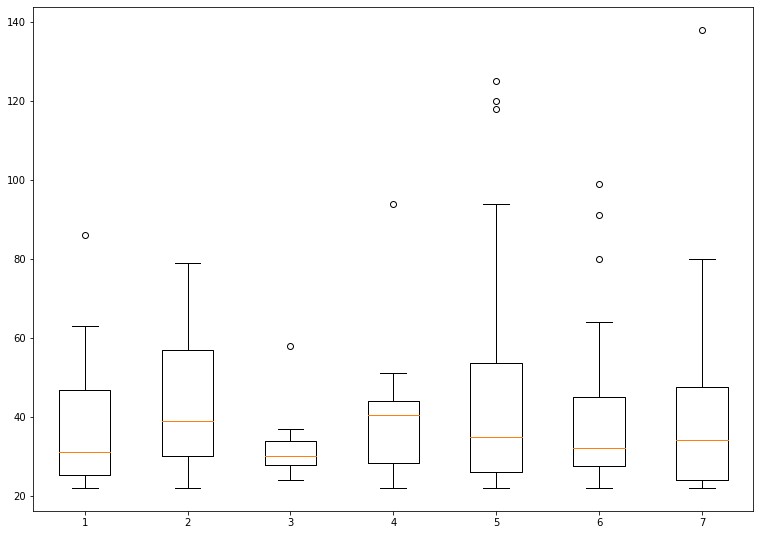

In [80]:
#operator_description = call_centr.loc[(call_centr['time']==0) & (call_centr['Время ожидания на линии']>5)].groupby(['Hour', 'День']).agg({'Время ожидания на линии': ['count','mean']}).unstack()
operator_description = call_centr.groupby(['Hour', 'День']).agg({'Время ожидания на линии': ['count','median']}).unstack()
#
#for col in operator_description.columns.values:
    #print(col[-2:]) 
operator_description.columns = [(col[1][0] + ' ' + col[2]) for col in operator_description.columns.values]
#[print(col[1][0],col[2]) for col in operator_description.columns.values]
operator_description.reset_index()

import matplotlib.pyplot as plt
import numpy as np
print(call_centr['Время ожидания на линии'].quantile(q=0.75))
data_1 = call_centr[(call_centr['День']=="ПН") & (call_centr['Время ожидания на линии']>call_centr['Время ожидания на линии'].quantile(q=0.75))]['Время ожидания на линии']
data_2 = call_centr[(call_centr['День']=="ВТ") & (call_centr['Время ожидания на линии']>call_centr['Время ожидания на линии'].quantile(q=0.75))]['Время ожидания на линии']
data_3 = call_centr[(call_centr['День']=="СР") & (call_centr['Время ожидания на линии']>call_centr['Время ожидания на линии'].quantile(q=0.75))]['Время ожидания на линии']
data_4 = call_centr[(call_centr['День']=="ЧТ") & (call_centr['Время ожидания на линии']>call_centr['Время ожидания на линии'].quantile(q=0.75))]['Время ожидания на линии']
data_5 = call_centr[(call_centr['День']=="ПТ") & (call_centr['Время ожидания на линии']>call_centr['Время ожидания на линии'].quantile(q=0.75))]['Время ожидания на линии']
data_6 = call_centr[(call_centr['День']=="СБ") & (call_centr['Время ожидания на линии']>call_centr['Время ожидания на линии'].quantile(q=0.75))]['Время ожидания на линии']
data_7 = call_centr[(call_centr['День']=="ВС") & (call_centr['Время ожидания на линии']>call_centr['Время ожидания на линии'].quantile(q=0.75))]['Время ожидания на линии']
data = [data_1, data_2, data_3, data_4, data_5, data_6, data_7]
#ata = [data_1]

fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data)
 
# show plot
plt.show()

#call_centr.plot(kind='line', title = "Данные по ", xlabel='Время ожидания на точке', ylabel='Количество заказов')


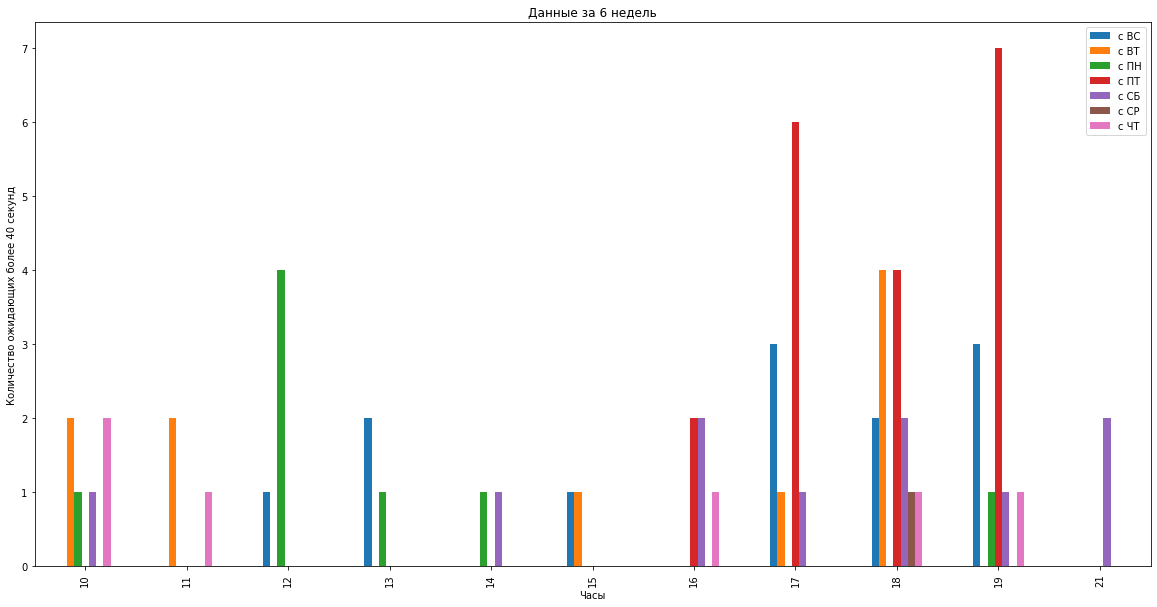

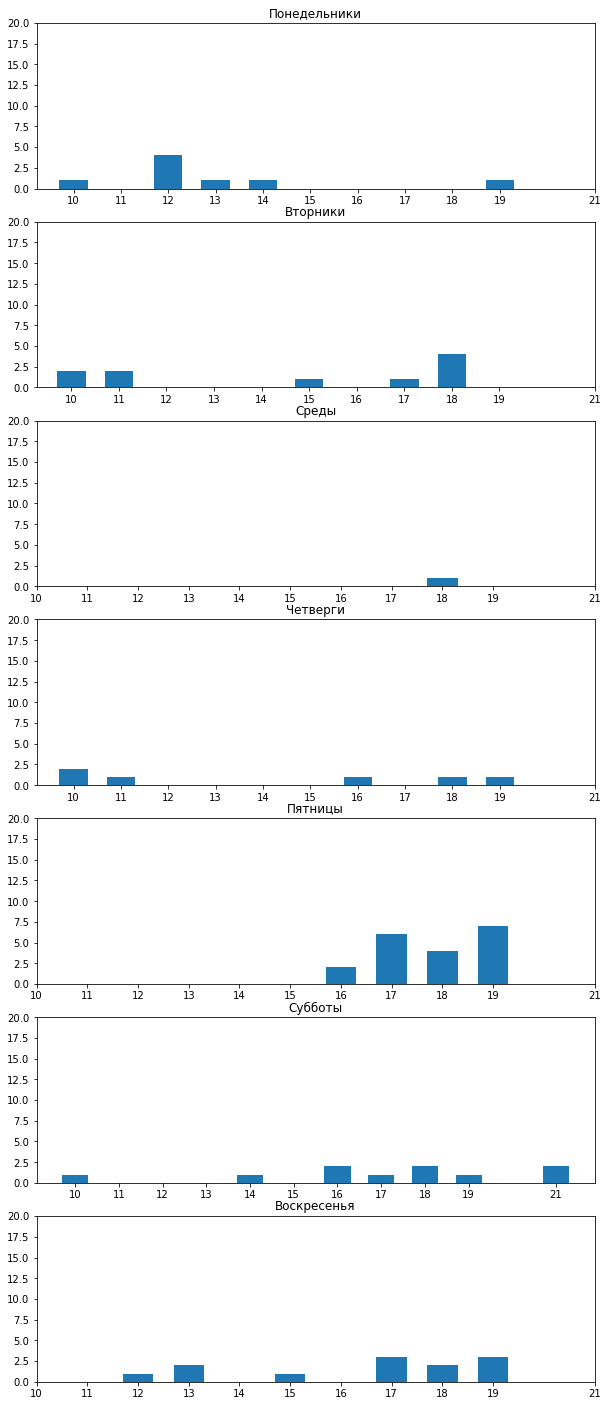

In [40]:
operator_description_success = call_centr[call_centr['Время ожидания на линии']>40].groupby(['Hour', 'День']).agg({'Время ожидания на линии': ['count','sum']}).unstack()
operator_description_success.columns = [(col[1][0] + ' ' + col[2]) for col in operator_description_success.columns.values]
#[print(col[1][0],col[2]) for col in operator_description.columns.values]
operator_description_success = operator_description_success.reset_index()
operator_description_success.set_index('Hour', inplace=True)

operator_description_success[['c ВС','c ВТ','c ПН','c ПТ','c СБ','c СР','c ЧТ']].plot(kind='bar', title = "Данные за 6 недель", xlabel='Часы', ylabel='Количество ожидающих более 40 секунд', use_index=True, figsize=(20,10))

plt.rcParams["figure.figsize"] = (10, 20)

fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7)
ax1.bar(operator_description_success.index, operator_description_success['c ПН'], width=0.6)
ax1.set_title('Понедельники')
ax1.set_ylim(0,20)
ax1.set_xticks(operator_description_success.index)
ax1.figure.set_size_inches(10, 25)
ax2.bar(operator_description_success.index, operator_description_success['c ВТ'], width=0.6)
ax2.set_title('Вторники')
ax2.set_ylim(0,20)
ax2.set_xticks(operator_description_success.index)
ax2.figure.set_size_inches(10, 25)
ax3.bar(operator_description_success.index, operator_description_success['c СР'], width=0.6)
ax3.set_title('Среды')
ax3.set_ylim(0,20)
ax3.set_xticks(operator_description_success.index)
ax3.figure.set_size_inches(10, 25)
ax4.bar(operator_description_success.index, operator_description_success['c ЧТ'], width=0.6)
ax4.set_title('Четверги')
ax4.set_ylim(0,20)
ax4.set_xticks(operator_description_success.index)
ax4.figure.set_size_inches(10, 25)
ax5.bar(operator_description_success.index, operator_description_success['c ПТ'], width=0.6)
ax5.set_title('Пятницы')
ax5.set_ylim(0,20)
ax5.set_xticks(operator_description_success.index)
ax5.figure.set_size_inches(10, 25)
ax6.bar(operator_description_success.index, operator_description_success['c СБ'], width=0.6)
ax6.set_title('Субботы')
ax6.set_ylim(0,20)
ax6.set_xticks(operator_description_success.index)
ax6.figure.set_size_inches(10, 25)
ax7.bar(operator_description_success.index, operator_description_success['c ВС'], width=0.6)
ax7.set_title('Воскресенья')
ax7.set_ylim(0,20)
ax7.set_xticks(operator_description_success.index)
ax7.figure.set_size_inches(10, 25)
fig.savefig('курьеры.png')


In [ ]:
operator_description_success[['s ВС','s ВТ','s ПН','s ПТ','s СБ','s СР','s ЧТ']].plot(kind='line', title = "Данные по ", xlabel='Время ожидания на точке', ylabel='Количество заказов')

In [41]:
a = call_centr.groupby(by='Operator')
call_centr.groupby(by='Operator')['time'].mean()

Operator
Бабенкова      90.477419
Гавриков      108.349206
Гуркина       102.039735
Ерёменко       80.835052
Колесина        0.000000
Кузьмичева     84.350000
Рожкова        71.000000
Соболева      107.300000
группа         65.833333
Name: time, dtype: float64

In [114]:

call_centr = pd.read_csv('Mango-Office_400122211_19_02_2022_13_40.csv', encoding='cp1251', sep=';')
def add_7(x):
    if str(x)[0]!='7':
        return int('7' + str(x))
    else:
        return x
    
    
courier_numbers = pd.read_excel('Номера курьеров.xlsx', header=None)
#print(courier_numbers.head())
call_centr['Набранный номер']=call_centr['Набранный номер'].apply(add_7)
call_centr.head()
concatination = pd.DataFrame()

for i in courier_numbers[0]:
    #print(i)   
    slice = call_centr[call_centr['Набранный номер']==i]
    concatination = pd.concat([concatination, slice], axis=0)

concatination


concatination.to_excel('2.xlsx')



In [113]:


def add_7(x):
    if str(x)[0]!='7':
        return int('7' + str(x))
    else:
        return x
    
    
courier_numbers = pd.read_excel('Номера курьеров.xlsx', header=None)
#print(courier_numbers.head())
call_centr['Кто звонил']=call_centr['Кто звонил'].apply(add_7)
call_centr.head()
concatination = pd.DataFrame()

for i in courier_numbers[0]:
    #print(i)   
    slice = call_centr[call_centr['Кто звонил']==i]
    concatination = pd.concat([concatination, slice], axis=0)

concatination.to_excel('1.xlsx')

In [85]:
call_centr.dtypes

Время                      datetime64[ns]
Кто звонил                          int64
Набранный номер                    object
Длительность, сек                   int64
time                                int64
Operator                           object
f_problem                            bool
Время ожидания на линии             int64
День                               object
Hour                                int64
dtype: object

In [20]:
for i in a:
    df_call = pd.DataFrame(i[1])
    print(df_call.dtypes)
    df_call['Между звонками'] = df_call.sort_values(by=['Время'], ascending=True)['Время'].diff()
    display(df_call)
    print(df_call['Между звонками'].mean())

Время                      datetime64[ns]
Длительность, сек                   int64
time                                int64
Operator                           object
Время ожидания на линии             int64
День                               object
Hour                                int64
dtype: object


,Время,"Длительность, сек",time,Operator,Время ожидания на линии,День,Hour,Между звонками
3,2022-02-12 18:48:00,209,153,Гавриков,48,СБ,18,0 days 00:02:00
4,2022-02-12 18:46:00,164,98,Гавриков,58,СБ,18,0 days 00:03:00
5,2022-02-12 18:43:00,159,146,Гавриков,5,СБ,18,0 days 00:20:00
10,2022-02-12 18:23:00,87,73,Гавриков,6,СБ,18,0 days 00:14:00
16,2022-02-12 18:09:00,173,159,Гавриков,6,СБ,18,0 days 00:15:00
20,2022-02-12 17:54:00,185,144,Гавриков,33,СБ,17,0 days 00:09:00
22,2022-02-12 17:45:00,142,98,Гавриков,36,СБ,17,0 days 00:02:00
23,2022-02-12 17:43:00,74,34,Гавриков,32,СБ,17,0 days 00:02:00
25,2022-02-12 17:41:00,184,77,Гавриков,99,СБ,17,0 days 00:03:00
28,2022-02-12 17:38:00,174,132,Гавриков,34,СБ,17,0 days 00:13:00


0 days 00:18:24.444444444
Время                      datetime64[ns]
Длительность, сек                   int64
time                                int64
Operator                           object
Время ожидания на линии             int64
День                               object
Hour                                int64
dtype: object


,Время,"Длительность, сек",time,Operator,Время ожидания на линии,День,Hour,Между звонками
2,2022-02-12 18:48:00,128,102,Гуркина,18,СБ,18,0 days 00:09:00
6,2022-02-12 18:39:00,121,99,Гуркина,14,СБ,18,0 days 00:13:00
9,2022-02-12 18:26:00,66,45,Гуркина,13,СБ,18,0 days 00:12:00
13,2022-02-12 18:14:00,115,102,Гуркина,5,СБ,18,0 days 00:04:00
14,2022-02-12 18:10:00,16,0,Гуркина,8,СБ,18,0 days 00:13:00
19,2022-02-12 17:57:00,109,87,Гуркина,14,СБ,17,0 days 00:18:00
26,2022-02-12 17:39:00,123,106,Гуркина,9,СБ,17,0 days 00:03:00
29,2022-02-12 17:36:00,119,79,Гуркина,32,СБ,17,0 days 00:17:00
32,2022-02-12 17:19:00,163,151,Гуркина,4,СБ,17,0 days 00:09:00
36,2022-02-12 17:10:00,122,105,Гуркина,9,СБ,17,0 days 00:39:00


0 days 00:20:53.684210526
Время                      datetime64[ns]
Длительность, сек                   int64
time                                int64
Operator                           object
Время ожидания на линии             int64
День                               object
Hour                                int64
dtype: object


,Время,"Длительность, сек",time,Operator,Время ожидания на линии,День,Hour,Между звонками
8,2022-02-12 18:30:00,121,108,Ерёменко,5,СБ,18,0 days 00:15:00
12,2022-02-12 18:15:00,123,95,Ерёменко,20,СБ,18,0 days 00:10:00
17,2022-02-12 18:05:00,71,58,Ерёменко,5,СБ,18,0 days 00:44:00
31,2022-02-12 17:21:00,111,99,Ерёменко,4,СБ,17,0 days 00:10:00
35,2022-02-12 17:11:00,84,72,Ерёменко,4,СБ,17,NaT


0 days 00:19:45
Время                      datetime64[ns]
Длительность, сек                   int64
time                                int64
Operator                           object
Время ожидания на линии             int64
День                               object
Hour                                int64
dtype: object


,Время,"Длительность, сек",time,Operator,Время ожидания на линии,День,Hour,Между звонками
1,2022-02-12 18:50:00,86,58,Кузьмичева,20,СБ,18,0 days 00:12:00
7,2022-02-12 18:38:00,555,540,Кузьмичева,7,СБ,18,0 days 00:18:00
11,2022-02-12 18:20:00,133,118,Кузьмичева,7,СБ,18,0 days 00:20:00
18,2022-02-12 18:00:00,128,110,Кузьмичева,10,СБ,18,0 days 00:06:00
21,2022-02-12 17:54:00,231,199,Кузьмичева,24,СБ,17,0 days 00:11:00
24,2022-02-12 17:43:00,122,94,Кузьмичева,20,СБ,17,0 days 00:04:00
27,2022-02-12 17:39:00,65,53,Кузьмичева,4,СБ,17,0 days 00:28:00
34,2022-02-12 17:11:00,102,88,Кузьмичева,6,СБ,17,0 days 00:20:00
38,2022-02-12 16:51:00,123,91,Кузьмичева,24,СБ,16,0 days 00:16:00
40,2022-02-12 16:35:00,151,80,Кузьмичева,63,СБ,16,0 days 00:12:00


0 days 00:21:39.130434782


In [12]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [13]:
from geopy import GoogleV3
place = "Мавзолей Ленина, Москва"
location = GoogleV3().geocode(place) # обрабатываем местоположение через API Google
print(location.address) # получаем полный адрес
print(location.location) # получаем полные координаты

ConfigurationError: Since July 2018 Google requires each request to have an API key. Pass a valid `api_key` to GoogleV3 geocoder to fix this error. See https://developers.google.com/maps/documentation/geocoding/usage-and-billing

In [106]:
#------------------------------ couriers analytics
import pandas as pd
import datetime 
from datetime import date, datetime, time, timedelta
import numpy as np 
pd.set_option("display.max_rows", None,'display.max_columns', None)
pd.set_option('display.max_rows', None)

CA = pd.read_excel('Доставки по курьерам аналитика.xlsx')
CA.isna().sum()

Торговое предприятие             0
Время открытия                2096
Время печати накладной         660
Планируемое время доставки     660
Время отправки доставки        661
Фактическое время доставки     665
Время закрытия                   4
Курьер                           4
Время в пути(мин)              669
Адрес                         7354
Тип заказа                       4
Возврат чека                     4
Номер чека                       4
dtype: int64

In [107]:
CA['Время открытия'].ffill(axis=0,inplace=True)
CA.drop(CA[CA['Возврат чека']=='Да'].index, inplace=True)
CA.drop(CA[CA['Курьер']=='Самовывоз'].index, inplace=True)
CA.dropna(inplace=True)

In [108]:
CA.info()
#datetime.datetime.now()
CA['Дата'] = CA['Время открытия'].apply(lambda x: x.date())

dropslabel = ['Сидоров Сергей', 'Фомин Кирилл Евгеньевич', 'Новиков Даниил',
       'Артём Великанов', 'Карасев Алексей', 'Остроухова Анна', 'Никита Мухин',
       'Герасин Андрей', 'Михаил Горлин', 'Макеев Владимир', 'Долгих Сергей',
       'Блинов Вадим', 'Лупачёв Виталий', 'Наумов Сергей', 'Ребров Георгий',
       'Федякин Валентин', 'Гришин Иван', 'Логвинов Александр',
       'Голанов Алексей', 'Журавлев Максим']

CA = CA[CA['Курьер'].isin(dropslabel) == False]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 43746 entries, 1 to 51106
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Торговое предприятие        43746 non-null  object        
 1   Время открытия              43746 non-null  datetime64[ns]
 2   Время печати накладной      43746 non-null  datetime64[ns]
 3   Планируемое время доставки  43746 non-null  datetime64[ns]
 4   Время отправки доставки     43746 non-null  datetime64[ns]
 5   Фактическое время доставки  43746 non-null  object        
 6   Время закрытия              43746 non-null  datetime64[ns]
 7   Курьер                      43746 non-null  object        
 8   Время в пути(мин)           43746 non-null  float64       
 9   Адрес                       43746 non-null  object        
 10  Тип заказа                  43746 non-null  object        
 11  Возврат чека                43746 non-null  object    

In [109]:
CA.head()

,Торговое предприятие,Время открытия,Время печати накладной,Планируемое время доставки,Время отправки доставки,Фактическое время доставки,Время закрытия,Курьер,Время в пути(мин),Адрес,Тип заказа,Возврат чека,Номер чека,Дата
1,Алроса,2021-08-01 10:40:42,2021-08-01 11:03:32.838,2021-08-01 11:40:20.000,2021-08-01 11:04:21.903,2021-08-01 11:18:41,2021-08-01 11:03:42.929,Тиганов Виталий,14.0,ул. Гагарина д. 32,Доставка курьером,Нет,94313.0,2021-08-01
2,Алроса,2021-08-01 11:18:46,2021-08-01 11:44:35.454,2021-08-01 12:18:06.000,2021-08-01 11:44:40.523,2021-08-01 11:56:45,2021-08-01 11:44:37.975,Конценебин Михаил,12.0,ул. Зеленина д. 6 кв./оф. 258 под. 4 эт. 1,Доставка курьером,Нет,94314.0,2021-08-01
3,Алроса,2021-08-01 11:22:51,2021-08-01 11:44:43.211,2021-08-01 12:22:08.090,2021-08-01 11:44:49.835,2021-08-01 12:06:52,2021-08-01 11:44:49.044,Конценебин Михаил,22.0,ул. Емлютина д. 11 кв./оф. 268 под. 3 эт. 11 д...,Доставка курьером,Нет,94315.0,2021-08-01
4,Алроса,2021-08-01 11:33:00,2021-08-01 12:00:26.507,2021-08-01 12:32:20.000,2021-08-01 12:07:06.658,2021-08-01 12:23:04,2021-08-01 12:00:29.116,Тиганов Виталий,15.0,ул. Наугорское шоссе д. 62 кв./оф. 33 под. 1 э...,Доставка курьером,Нет,94316.0,2021-08-01
5,Алроса,2021-08-01 11:34:32,2021-08-01 12:03:19.056,2021-08-01 12:33:20.000,2021-08-01 12:03:23.073,2021-08-01 12:23:14,2021-08-01 12:03:20.781,Валерия Петракова,19.0,ул. Карачевское шоссе д. 77 корп./стр. к1 кв./...,Доставка курьером,Нет,94317.0,2021-08-01


<ipython-input-144-9528b56396d4>:3: RuntimeWarning: divide by zero encountered in true_divide
  grouped = CA.groupby(by=['Курьер', 'Дата'])['Время отправки доставки'].agg(lambda x: x.count()/((x.max() - x.min()).total_seconds()/3600)).unstack().transpose()


Волчков Сергей
Даниил Абросимов
Пителин Дмитрий
курьер стажёр 1
Кнутов Александр
Пеший курьер горького
Кобеев Артём
Дмитрий Буянов
Конценебин Михаил
Петрова Александра
Черников Дмитрий
Владимир Бутенин
Волчков Сергей
Кобеев Артём
Раменский Вадим
Герасичкин Даниил
курьер стажёр 1
Дмитрий Буянов
Кристина Воякина
курьер стажёр2


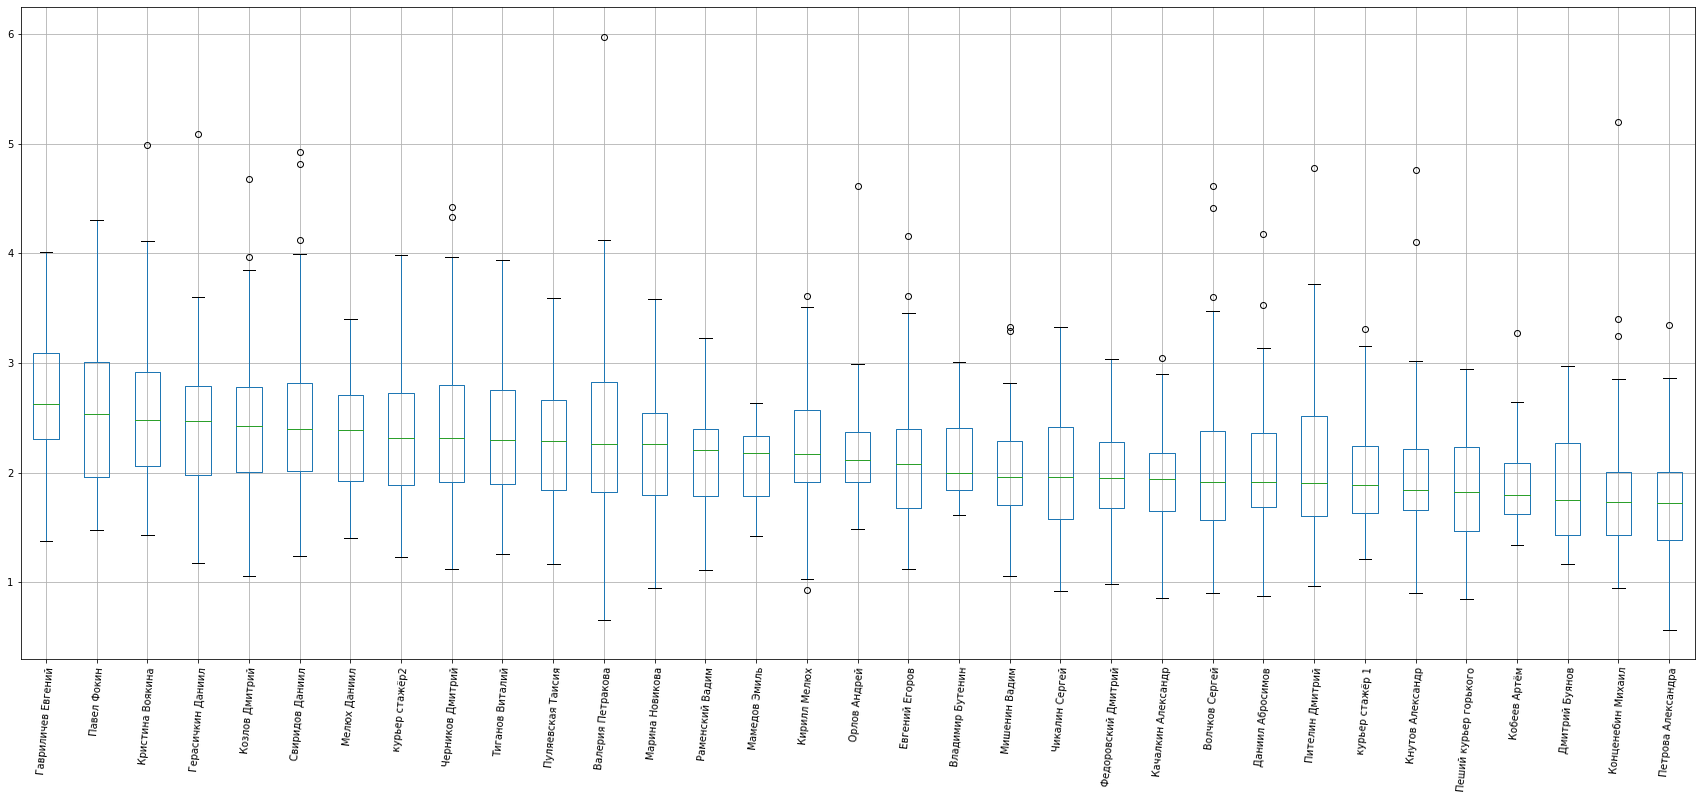

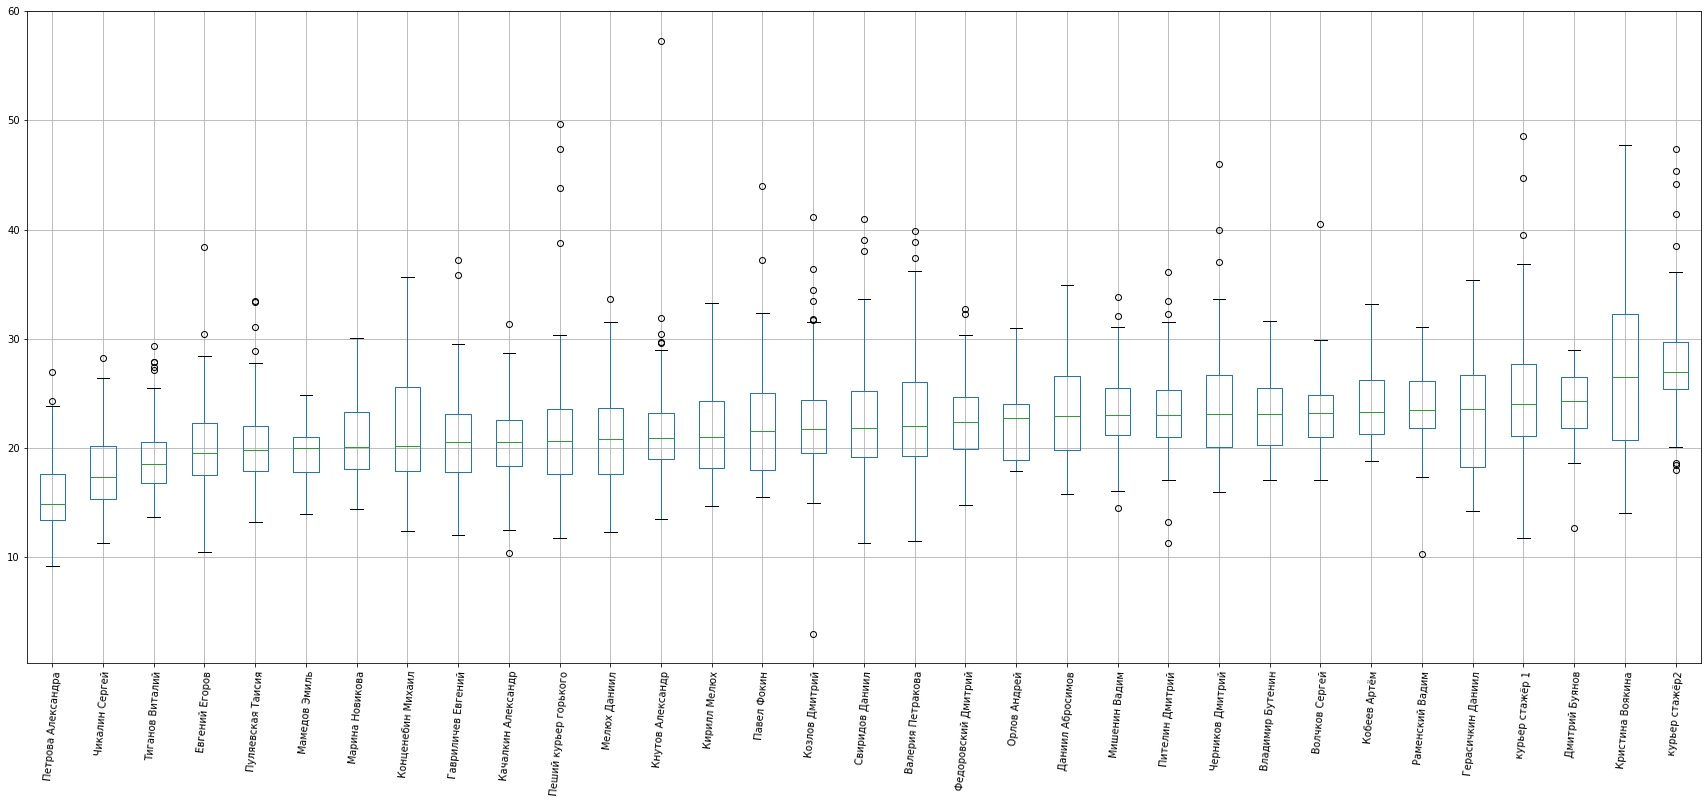

In [144]:
#grouped = CA.groupby(by=['Курьер', 'Дата'])['Номер чека'].count().unstack().transpose()

grouped = CA.groupby(by=['Курьер', 'Дата'])['Время отправки доставки'].agg(lambda x: x.count()/((x.max() - x.min()).total_seconds()/3600)).unstack().transpose()

for i in grouped.columns:
    grouped.loc[grouped[i] > 100, i] = np.nan


#display(grouped2)

CA.groupby(by=['Курьер'])['Номер чека'].count().sort_values(ascending=True).index
CA.groupby(by=['Курьер'])['Номер чека'].count().sort_values(ascending=True)

meds = grouped.median()
meds.sort_values(ascending=False, inplace=True)
grouped = grouped[meds.index]

for i in grouped.columns[-10:]:
    print(i)
#print(grouped2.columns[-10:])

grouped.plot(kind='box', figsize=(30,12), rot = 85, grid=True).get_figure().savefig('курьеры.png')

grouped2 = CA.groupby(by=['Курьер', 'Дата'])['Время в пути(мин)'].mean().unstack().transpose()

meds = grouped2.median()
meds.sort_values(ascending=True, inplace=True)

grouped2 = grouped2[meds.index]

for i in grouped2.columns[-10:]:
    print(i)
#print(grouped2.columns[-10:])

grouped2.plot(kind='box', figsize=(30,12), rot = 85, grid=True)

C:\Users\user\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\user\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\user\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\user\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


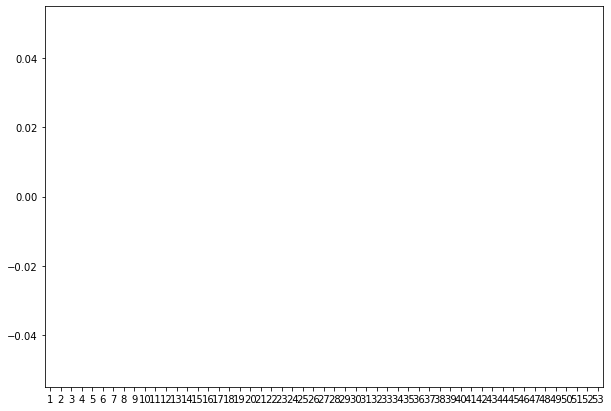

In [57]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
  
# Creating dataset
np.random.seed(10)
 
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(grouped)

# show plot
plt.show()